In [26]:
import os
import json
import librosa
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_text

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, GlobalAveragePooling1D, TimeDistributed, Bidirectional, Flatten, Input, LSTM, Dense, Dropout, Lambda 
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from transformers import Wav2Vec2Processor, Wav2Vec2FeatureExtractor, Wav2Vec2Model, Wav2Vec2ForCTC
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load model directly wav2vec2
from transformers import Wav2Vec2Processor, Wav2Vec2Model



In [27]:
class DataPreparation:
    EMOTION_MAP = {
        '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
        '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
    }

    MODALITY_MAP = {
        '01': 'full-AV', '02': 'video-only', '03': 'audio-only'
    }

    VOCAL_CHANNEL_MAP = {
        '01': 'speech', '02': 'song'
    }

    INTENSITY_MAP = {
        '01': 'normal', '02': 'strong'
    }

    STATEMENT_MAP = {
        '01': 'Kids are talking by the door',
        '02': 'Dogs are sitting by the door'
    }

# ---------------------------------------------------------------------------------------- #
    def __init__(self, dataset_path, json_file='Metadata.json'):
        self.dataset_path = dataset_path
        self.json_file = json_file
        self.emotion_counts = {}
# ---------------------------------------------------------------------------------------- #
    def load_dataset(self, feature_type = "MFCC-16000-13"):
        """Load dataset, extract features and labels with extra checks and summaries."""
        X, y = [], []
        file_count = 0
        max_len = 0  # Track the maximum feature length for padding
        plotted_emotions = set() # Track plotted emotions
    
        if not os.path.exists(self.dataset_path):
            raise FileNotFoundError(f"Dataset path '{self.dataset_path}' does not exist. Please check the path.") 
            return np.array(X), np.array(y)
            
        # Split the feature_type string by the hyphen (-)
        parts = feature_type.split('-')
        
        # Assign to variables
        method = parts[0]      # "MFCC" or "WAV2VEC"
        sample_rate = int(parts[1])  # 16000 as an integer
        if method == "MFCC":
           num_coeffs = int(parts[2]) if len(parts) > 0 else None
        
        # Printing the parsed variables
        print(f"Method: {method}")
        print(f"Sample Rate: {sample_rate}")
        if method == "MFCC":
            print(f"Number of Coefficients: {num_coeffs}")
       
        # Scan and validate files
        valid_files = self.scan_files()
        print(f"\n Extracting the {method} type feature with sample_rate: {sample_rate}\n")
        for file_path, file, parts in valid_files:
            file_count += 1
            if file_count % 100 == 0:
                    print(f"\n Processing  the  file Number: {file_count}")
            (modality_code, vocal_channel_code, emotion_code, 
             emotional_intensity_code, statement_code, 
             repetition_code, actor_id_code) = parts
            actor_gender_code = "Male" if int(actor_id_code) % 2 != 0 else "Female"

            emotion = self.EMOTION_MAP.get(emotion_code)

            if emotion:
                #---------------------------------------------------------------#
                # Track emotion count
                self.emotion_counts[emotion] = self.emotion_counts.get(emotion, 0) + 1
                #---------------------------------------------------------------#
                # # Append metadata to JSON
                # self.append_meta_data(
                #     file, modality_code, vocal_channel_code, 
                #     emotion_code, emotional_intensity_code, 
                #     statement_code, repetition_code, actor_id_code
                # )
                #---------------------------------------------------------------#
                # Plot waveform and spectrogram only if the emotion has not been plotted before
                if emotion not in plotted_emotions:
                    print(f"\nPlotting for Emotion: {emotion}\n"
                          f"Modality: {modality_code}, Vocal Channel: {vocal_channel_code}, Intensity: {emotional_intensity_code}, Statement: {statement_code}, Actor ID: {actor_id_code},  Actor_Gender: {actor_gender_code}")
                    self.plot_waveform_and_spectrogram(file_path, emotion)
                    plotted_emotions.add(emotion)
                #---------------------------------------------------------------#
                # Extract features
                 # Extract features based on type
                if method == "MFCC":
                    features = self.extract_mfcc_features(file_path, resampling_freq=sample_rate, n_mfcc=num_coeffs, start_time=0.5, end_time=3)
                elif method == "WAV2VEC":
                    features = self.extract_wav2vec_features(file_path, sample_rate)
                else:
                    raise ValueError("Invalid feature_type. Choose 'MFCC' or 'WAV2VEC'.")
                #---------------------------------------------------------------#
                X.append(features)
                y.append(emotion)
                # Update max_len for padding
                max_len = max(max_len, features.shape[0])
                #---------------------------------------------------------------#
                # # Optional preview of first 5 files
                # if file_count <= 5:
                #     print(f"✅ Processed: {file_path}")
                #     print(f"   Emotion: {emotion}")
                #     print(f"   MFCC Shape: {features.shape}")
                #     print(f"   MFCC Sample: {features[:5]} ...\n")
                #---------------------------------------------------------------#

        # Pad the features to the same length
        X_padded = self.pad_features(X, max_len)
        # Final summary
        print(f"\n✅ Dataset Extracted and Loaded Successfully!")
        print(f"Total audio files processed: {file_count}")
        print("Emotion distribution:")
        for emotion, count in self.emotion_counts.items():
            print(f"  {emotion}: {count} files")
        return np.array(X_padded), np.array(y)

# ---------------------------------------------------------------------------------------- #
    def scan_files(self):
        """Scan dataset directory for valid .wav files with correct naming convention."""
        print(f"\n🔍 Scanning dataset directory: {self.dataset_path}\n")

        valid_files = []

        for root, _, files in os.walk(self.dataset_path):
            for file in files:
                if file.endswith(".wav"):
                    file_path = os.path.join(root, file)
                    filename_without_extension = file.split('.')[0]
                    parts = filename_without_extension.split("-")
                    if len(parts) < 7:
                        print(f"⚠️ Skipping file with unexpected name format: {file}")
                        continue

                    valid_files.append((file_path, file, parts))

        print(f"✅ Found {len(valid_files)} valid audio files.\n")
        return valid_files
# ---------------------------------------------------------------------------------------- #
    def append_meta_data(self, file, modality_code, vocal_channel_code, emotion_code, 
                            emotional_intensity_code, statement_code, repetition_code, actor_id_code):
        """Append extracted metadata to JSON file."""
        new_entry = {
            "Filepath": file,
            "Modality": self.MODALITY_MAP.get(modality_code, "Unknown"),
            "Vocal_Channel": self.VOCAL_CHANNEL_MAP.get(vocal_channel_code, "Unknown"),
            "Emotion": self.EMOTION_MAP.get(emotion_code, "Unknown"),
            "Emotional_Intensity": self.INTENSITY_MAP.get(emotional_intensity_code, "Unknown"),
            "Statement": self.STATEMENT_MAP.get(statement_code, "Unknown"),
            "Repetition": repetition_code,
            "Actor_Id": actor_id_code,
            "Actor_Gender": "Male" if int(actor_id_code) % 2 != 0 else "Female" 
        }

        try:
            with open(self.json_file, 'r') as file:
                data = json.load(file)
        except FileNotFoundError:
            data = []

        data.append(new_entry)

        with open(self.json_file, 'w') as file:
            json.dump(data, file, indent=4)

        # print(f"📁 Data appended for file: {file}")
# ---------------------------------------------------------------------------------------- #
    # Function to plot waveform and spectrogram
    def plot_waveform_and_spectrogram(self, audio_path, emotion):
        # Load audio
        Audio(audio_path)
        audio, sr = librosa.load(audio_path, sr=None)
    
        # Plot waveform
        plt.figure(figsize=(14, 5))
        plt.subplot(1, 2, 1)
        librosa.display.waveshow(audio, sr=sr)
        plt.title(f"Waveform (Emotion: {emotion})")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
    
        # Plot spectrogram
        plt.subplot(1, 2, 2)
        spectrogram = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
        librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='log')
        plt.title(f"Spectrogram (Emotion: {emotion})")
        plt.colorbar(format="%+2.0f dB")
    
        plt.tight_layout()
        plt.show()

        normalized_audio, sr = self.preprocess_audio(audio_path, target_sr=48000)
        # Plot waveform
        plt.figure(figsize=(14, 5))
        plt.subplot(1, 2, 1)
        librosa.display.waveshow(normalized_audio, sr=sr)
        plt.title(f"preprocess audio Waveform (Emotion: {emotion})")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
    
        # Plot spectrogram
        plt.subplot(1, 2, 2)
        spectrogram = librosa.amplitude_to_db(np.abs(librosa.stft(normalized_audio)), ref=np.max)
        librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='log')
        plt.title(f"preprocess audio Spectrogram (Emotion: {emotion})")
        plt.colorbar(format="%+2.0f dB")
    
        plt.tight_layout()
        plt.show()
    
# ---------------------------------------------------------------------------------------- #
    def preprocess_audio(self, audio_path, target_sr=16000):
        # Load audio
        audio, sr = librosa.load(audio_path, sr=target_sr)
        # Trim silence
        trimmed_audio, _ = librosa.effects.trim(audio, top_db=20)
        # Normalize
        normalized_audio = librosa.util.normalize(trimmed_audio)
        return normalized_audio, sr
# ---------------------------------------------------------------------------------------- #
    # MFCC Extraction
    def extract_mfcc_features(self, file_path, resampling_freq=16000, n_mfcc=13, start_time=0.5, end_time=3):
        preprocessed_audio, sr = self.preprocess_audio(file_path, resampling_freq)

        # Extract MFCCs
        mfccs = librosa.feature.mfcc(y=preprocessed_audio, sr=sr, n_mfcc=n_mfcc)
        
        # Calculate Delta and Delta-Delta
        delta_mfccs = librosa.feature.delta(mfccs)
        delta_delta_mfccs = librosa.feature.delta(mfccs, order=2)
    
        # Mel spectrogram
        mel_spec = librosa.feature.melspectrogram(y=preprocessed_audio, sr=sr, n_mels=40)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
        # Concatenate features
        combined_features = np.concatenate([np.mean(mfccs, axis=1), np.mean(delta_mfccs, axis=1), 
                                           np.mean(delta_delta_mfccs, axis=1), np.mean(mel_spec_db, axis=1)])
    
        return combined_features
    
    
    # ---------------------------------------------------------------------------------------- #
    # Combined Wav2Vec2 Processing (Feature Extraction)
    def extract_wav2vec_features(self, file_path, resampling_freq = 16000):
        """
        Process an audio file using Wav2Vec2.

        This function extracts Wav2Vec2 embeddings (features) for use in downstream tasks like classification.
        This allows you to capture both low-level acoustic features.

        :param file_path: Path to the audio file.
        :param resampling_freq: Resampling frequency for the audio file. Default is 16000.
        :return: embeddings - Numpy array of shape [time_steps, feature_dim]
        """
        try:
            preprocessed_audio, sr = self.preprocess_audio(file_path, resampling_freq)
            # Load audio file and resample to 16kHz (required by Wav2Vec2)
            # y, sr = librosa.load(file_path, sr=resampling_freq)

            # Load necessary models and processors
            model_path = "/kaggle/input/wav2vec2-base/wav2vec2-base"
            feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_path)
            model = Wav2Vec2Model.from_pretrained(model_path)
            
            # Enable gradient checkpointing if needed
            model.gradient_checkpointing_enable()
            
            # Prepare input for both models
            inputs = feature_extractor(preprocessed_audio, sampling_rate=sr, return_tensors="pt")

            # Extract embeddings (Wav2Vec2 base model output)
            with torch.no_grad():
                embeddings = model(**inputs).last_hidden_state
                embeddings = embeddings.squeeze(0).numpy()  # Shape [time_steps, feature_dim]

            # Return embeddings
            return embeddings
        
        except Exception as e:
            print(f"Error processing the file {file_path}: {str(e)}")
            return None
    # ---------------------------------------------------------------------------------------- #
    def pad_features(self, features, max_len, padding_value=0):
        """
        Pad the feature arrays to the same length (max_len) with the padding_value.
        """
        padded_features = []
        for feature in features:
            # Calculate how much padding is needed
            pad_size = max_len - feature.shape[0]
            if pad_size > 0:
                # Pad with the specified padding value (e.g., zeros)
                padded_features.append(np.pad(feature, ((0, pad_size), (0, 0)), mode='constant', constant_values=padding_value))
            else:
                padded_features.append(feature)  # No padding needed
        return np.array(padded_features)

In [3]:
focal_loss(alpha=0.25, gamma=2.0):
    def loss_fn(y_true, y_pred):
        cce = SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
        cross_entropy = cce(y_true, y_pred)
        pt = tf.exp(-cross_entropy)
        focal_weight = alpha * (1 - pt) ** gamma
        focal_loss = focal_weight * cross_entropy
        return tf.reduce_mean(focal_loss)
    return loss_fn

In [4]:
def build_lstm_model(input_shape, num_classes):
    """Build an LSTM model."""
    print(f"\ninput_shape shape: {input_shape}")
    print(f"num_classes shape: {num_classes}")
    model=Sequential([
    Input(shape=input_shape),
    LSTM(256,return_sequences=False),
    Dense(128,activation='relu'),
    Dropout(0.2),
    Dense(64,activation='relu'),
    Dropout(0.2),
    Dense(num_classes,activation='softmax')
    ])

    
    return model

In [5]:
def build_cnn_model(input_shape, num_classes):  
    print(f"\ninput_shape shape: {input_shape}")
    print(f"num_classes shape: {num_classes}")
    model = Sequential([
        Input(shape=input_shape),
        # Block 1
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        # Dropout(0.25),
    
        # Block 2
        Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),
    
        # Block 3
        Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
    
        # Global pooling
        GlobalAveragePooling1D(),
    
        # Dense layers
        Dense(128,activation='relu'),
        Dropout(0.2),
        # Dense layers
        Dense(64,activation='relu'),
        Dropout(0.2),
        Dense(num_classes,activation='softmax')
    ])

    return model

In [6]:
def build_lstm_cnn_model(input_shape, num_classes):
    """Build a CNN + LSTM model."""
    print(f"\ninput_shape shape: {input_shape}")
    print(f"num_classes shape: {num_classes}")

        # model = Sequential([
        # Input(shape=input_shape),

        # # Block 1
        # Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        # BatchNormalization(),
        # MaxPooling1D(pool_size=2),
        # Dropout(0.25),
    
        # # Block 2
        # Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
        # BatchNormalization(),
        # MaxPooling1D(pool_size=2),
        # Dropout(0.25),
    
        # # Block 3
        # Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
        # BatchNormalization(),
        # MaxPooling1D(pool_size=2),
        # Dropout(0.2),

        # LSTM(256,return_sequences=True),
        # LSTM(128,return_sequences=False),
        # Dense(128,activation='relu'),
        # Dropout(0.2),
        # # Dense layers
        # Dense(64,activation='relu'),
        # Dropout(0.2),
        # Dense(num_classes,activation='softmax')
        # ])

    
#     model = Sequential([
#         Input(shape=input_shape),

#         # Block 1
#         Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
#         BatchNormalization(),
#         MaxPooling1D(pool_size=2),
#         Dropout(0.25),
    
#         # Block 2
#         Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
#         BatchNormalization(),
#         MaxPooling1D(pool_size=2),
#         Dropout(0.25),
    
#         # Block 3
#         Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
#         BatchNormalization(),
#         MaxPooling1D(pool_size=2),
#         Dropout(0.2),

#         Bidirectional(LSTM(256,return_sequences=True)),
#         Bidirectional(LSTM(128,return_sequences=False)),
#         Dense(128,activation='relu'),
#         Dropout(0.2),
#         # Dense layers
#         Dense(64,activation='relu'),
#         Dropout(0.2),
#         Dense(num_classes,activation='softmax')
# ])


#     model = Sequential([
#         Input(shape=input_shape),

#         # Block 1
#         Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
#         BatchNormalization(),
#         MaxPooling1D(pool_size=2),
#         Dropout(0.25),
    
#         # Block 2
#         Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
#         BatchNormalization(),
#         MaxPooling1D(pool_size=2),
#         Dropout(0.25),
    
#         # Block 3
#         Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
#         BatchNormalization(),
#         MaxPooling1D(pool_size=2),
#         Dropout(0.2),

#         LSTM(256,return_sequences=True),
#         LSTM(128,return_sequences=True),
#         LSTM(64,return_sequences=False),
#         Dense(64,activation='relu'),
#         Dropout(0.2),
#         # Dense layers
#         Dense(32,activation='relu'),
#         Dropout(0.2),
#         Dense(num_classes,activation='softmax')
# ])

    model = Sequential([
        Input(shape=input_shape),

        # Block 1
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        # Dropout(0.25),
    
        # Block 2
        Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),
    
        # Block 3
        Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        # Dropout(0.2),

        LSTM(128,return_sequences=True),
        LSTM(64,return_sequences=False),
        Dense(64,activation='relu'),
        Dropout(0.2),
        # Dense layers
        Dense(32,activation='relu'),
        Dropout(0.2),
        Dense(num_classes,activation='softmax')
])

    return model

In [7]:
def plot_training_history(history):
    """Plot training and validation loss/accuracy."""
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.xlabel('No. of Epochs')
    plt.ylabel('loss')
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
  
    plt.subplot(1, 2, 2)
    plt.xlabel('No. of Epochs')
    plt.ylabel('accuracy')
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.legend()

    plt.show()

In [8]:
def train_model(X, y, model_type='LSTM', test_size=0.2, random_state=93282494, epochs=30, batch_size=32, learning_rate = 0.001, loss = focal_loss(), optimizer_sel = RMSprop):
    # """Train and evaluate the model with given dataset, supporting both LSTM and CNN models."""

    # Encode labels
    le = LabelEncoder()
    y = le.fit_transform(y)
    labels = le.classes_

   
    # # Visualize features
    # print("\n🔍 Visualizing feature embeddings using t-SNE...")
    # visualize_features(X, y, le)
    # print("✅ Feature visualization completed.")


     # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)


    # Model selection
    if model_type == 'LSTM':
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1]))  
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1]))  
        # For LSTM, the input shape should be (timesteps, features), which is already handled by reshaping
        model = build_lstm_model(input_shape=(X_train.shape[1], 1), num_classes=len(labels))
    elif model_type == 'CNN':
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1)) 
        # For CNN, the input shape should be (samples, timesteps, features), which is also handled by reshaping
        model = build_cnn_model(input_shape=(X_train.shape[1], 1), num_classes=len(labels))
    elif model_type == 'LSTM_CNN':
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1)) 
        # For LSTM + CNN, both types of layers are used together, the reshaped input data works here as well
        model = build_lstm_cnn_model(input_shape=(X_train.shape[1], 1), num_classes=len(labels))
    else:
        raise ValueError(f"Unsupported model_type '{model_type}'. Use 'LSTM', 'CNN', or 'LSTM_CNN'.")

    # ----------------------------------------------------------------------------------------------------------------- #
    optimizer = optimizer_sel(learning_rate)  # Ensure optimizer is created separately
    model.compile(optimizer=optimizer, 
                  loss=loss, 
                  metrics=['accuracy'])
    
    print("✅ Model compiled and this is its visualization.")
    model.summary()
    # ----------------------------------------------------------------------------------------------------------------- #
     # Define ReduceLROnPlateau callback to adjust learning rate dynamically
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',    # Monitor validation loss
        factor=0.5,            # Reduce learning rate by half when triggered
        patience=5,            # Wait 3 epochs before reducing learning rate
        min_lr=1e-6,           # Set a lower bound for the learning rate
        verbose=1              # Print updates when learning rate is reduced
    )
    
    # Define EarlyStopping callback to prevent overfitting and unnecessary training
    early_stopping = EarlyStopping(
        monitor='val_loss',           # Monitor validation loss
        patience=10,                   # Stop training if no improvement for 5 epochs
        restore_best_weights=True,     # Restore the best model weights
        verbose=1                      # Print a message when training stops
    )
    
    # Train the model with defined callbacks
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,                     # Show training progress
        callbacks=[reduce_lr, early_stopping]  # Include callbacks for adaptive training
    )
    print("✅ Training the Parameters of selected Model is completed")

    return model, history, labels, X_train, X_test, y_train, y_test



In [9]:
def plot_confusion_matrix(y_true, y_pred, labels):
    """Plot confusion matrix."""
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


In [10]:
def visualize_features(X, y, label_encoder, random_state = 93282494, n_components = 2):
    """Visualize the features in 2D using t-SNE."""
    tsne = TSNE(n_components=2, random_state=random_state)
    reduced_features = tsne.fit_transform(X)

    plt.figure(figsize=(10, 6))
    for label in range(len(label_encoder.classes_)):
        idx = y == label
        plt.scatter(reduced_features[idx, 0], reduced_features[idx, 1], label=label_encoder.classes_[label])
    
    plt.legend()
    plt.title("t-SNE Visualization of Extracted Features")
    plt.show()

In [11]:
def evaluate_model( model, history, labels, X_train, X_test, y_train, y_test ):
    """Train and evaluate the model with given dataset."""

    # Making predictions
    print("\n🔮 Making predictions on the test set...")
    y_pred_train = model.predict(X_train).argmax(axis=1)  # Get the class with the highest probability for train set
    y_pred_test = model.predict(X_test).argmax(axis=1)  # Get the class with the highest probability
    print("✅ Predictions completed.\n")
    
    # Calculate and print accuracy for both train and test set
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    
    print(f"🏋️‍♂️ Train Accuracy: {train_accuracy * 100:.2f}%")
    print(f"🔑 Test Accuracy: {test_accuracy * 100:.2f}%\n")
    
    # Generate and print detailed classification report
    print("\n📊 Generating Classification Report...")
    report = classification_report(y_test, y_pred_test, target_names=labels, zero_division=0)
    print("\nClassification Report:\n", report)

    
    # Plot confusion matrix
    print("\n🧩 Plotting Confusion Matrix...")
    plot_confusion_matrix(y_test, y_pred_test, labels)
    print("✅ Confusion Matrix plot displayed.")
    
    # Plot the training history (accuracy and loss over epochs)
    print("\n📈 Plotting Training History (Loss and Accuracy)...")
    plot_training_history(history)
    print("✅ Training history plot displayed.")



In [28]:

DATASET_PATH = '/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/'
data_prep = DataPreparation(dataset_path=DATASET_PATH)

Method: MFCC
Sample Rate: 48000
Number of Coefficients: 40

🔍 Scanning dataset directory: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/

✅ Found 1440 valid audio files.


 Extracting the MFCC type feature with sample_rate: 48000


Plotting for Emotion: surprised
Modality: 03, Vocal Channel: 01, Intensity: 01, Statement: 01, Actor ID: 02,  Actor_Gender: Female


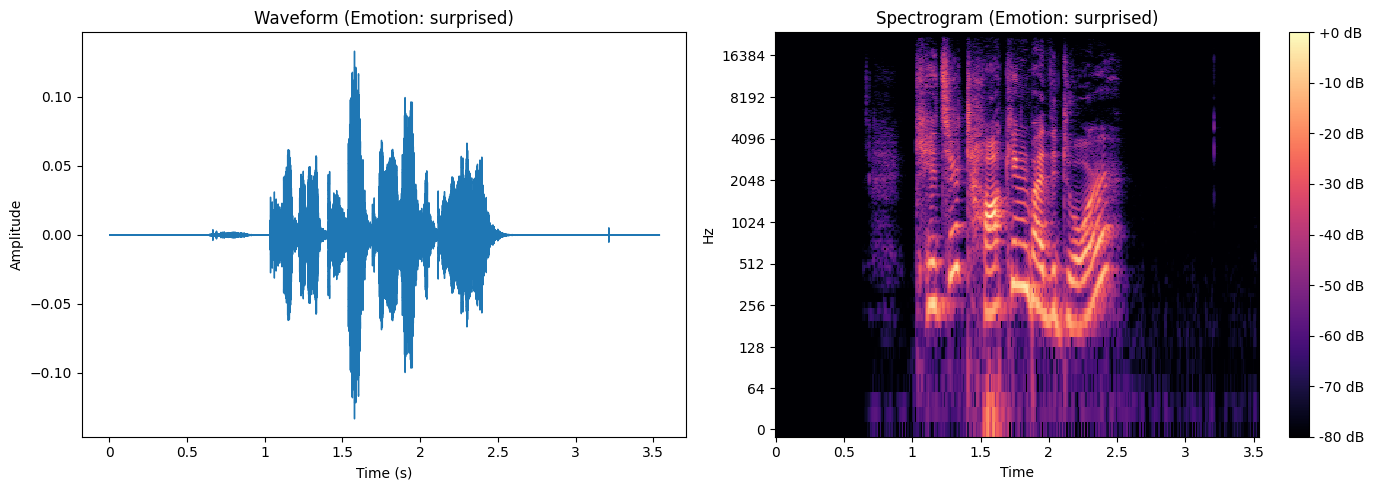

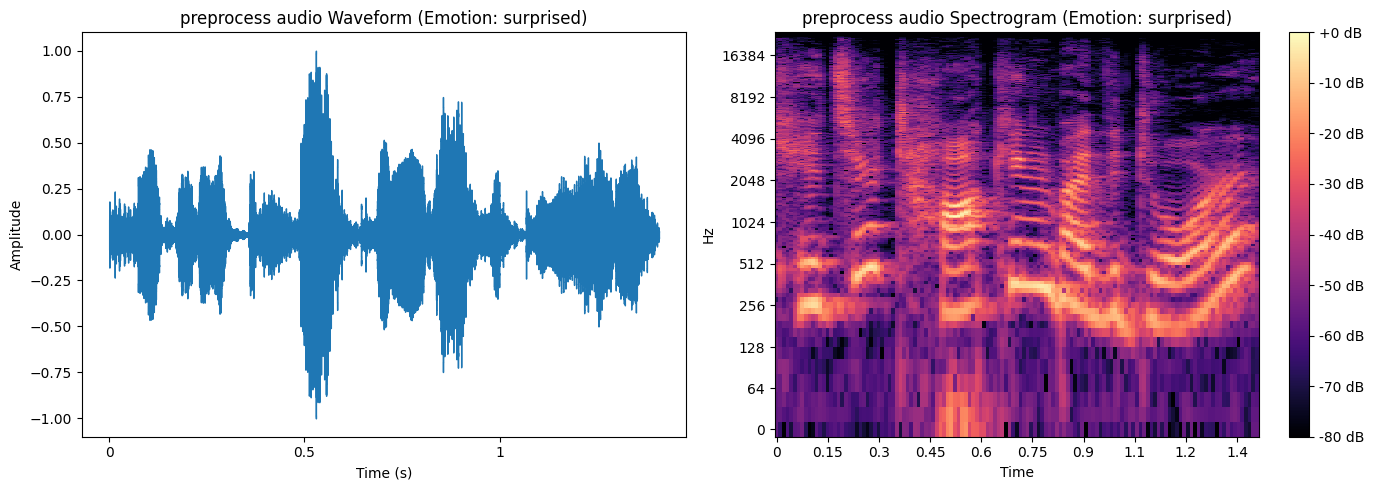


Plotting for Emotion: neutral
Modality: 03, Vocal Channel: 01, Intensity: 01, Statement: 01, Actor ID: 02,  Actor_Gender: Female


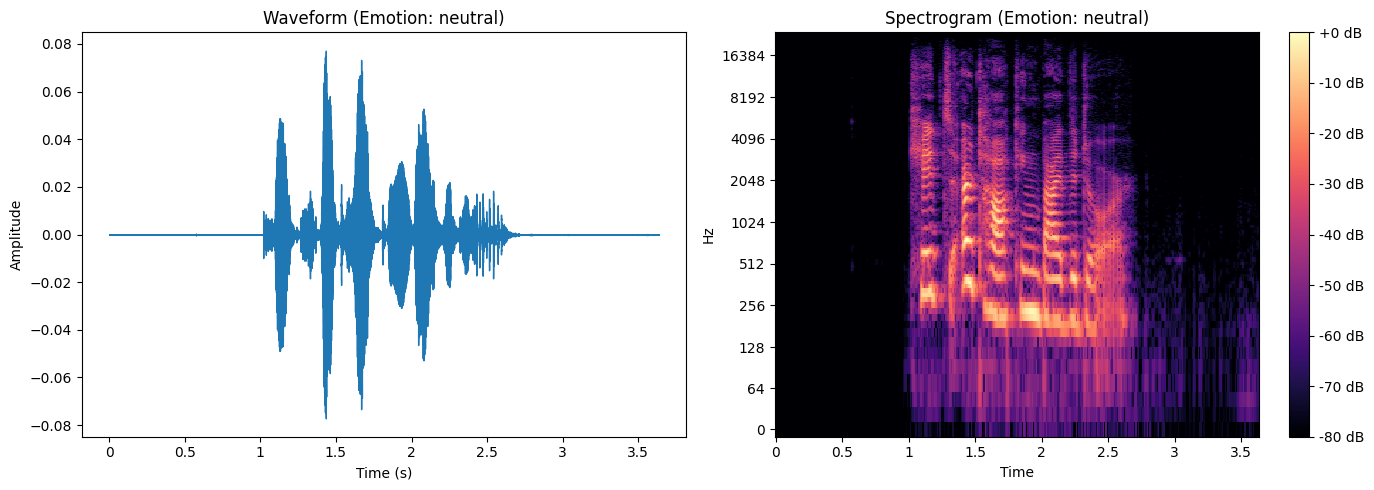

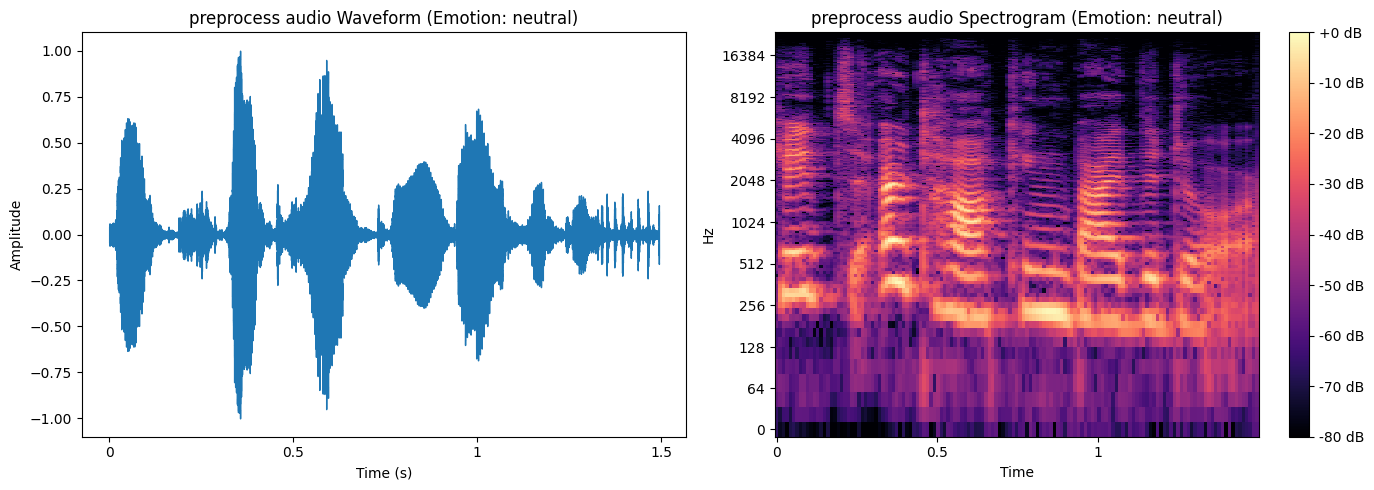


Plotting for Emotion: disgust
Modality: 03, Vocal Channel: 01, Intensity: 02, Statement: 01, Actor ID: 02,  Actor_Gender: Female


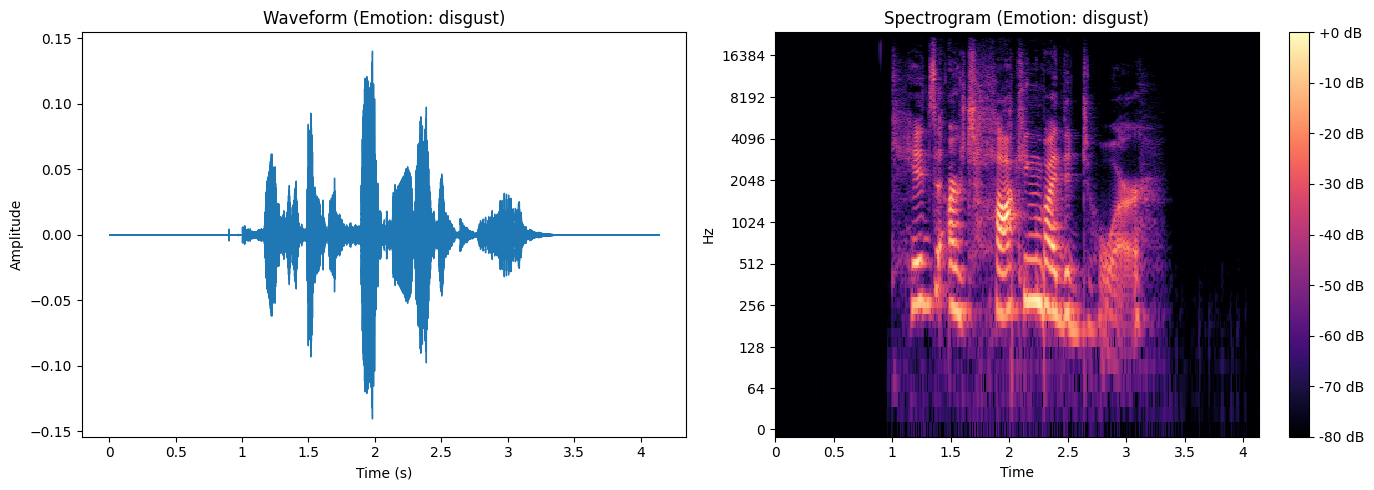

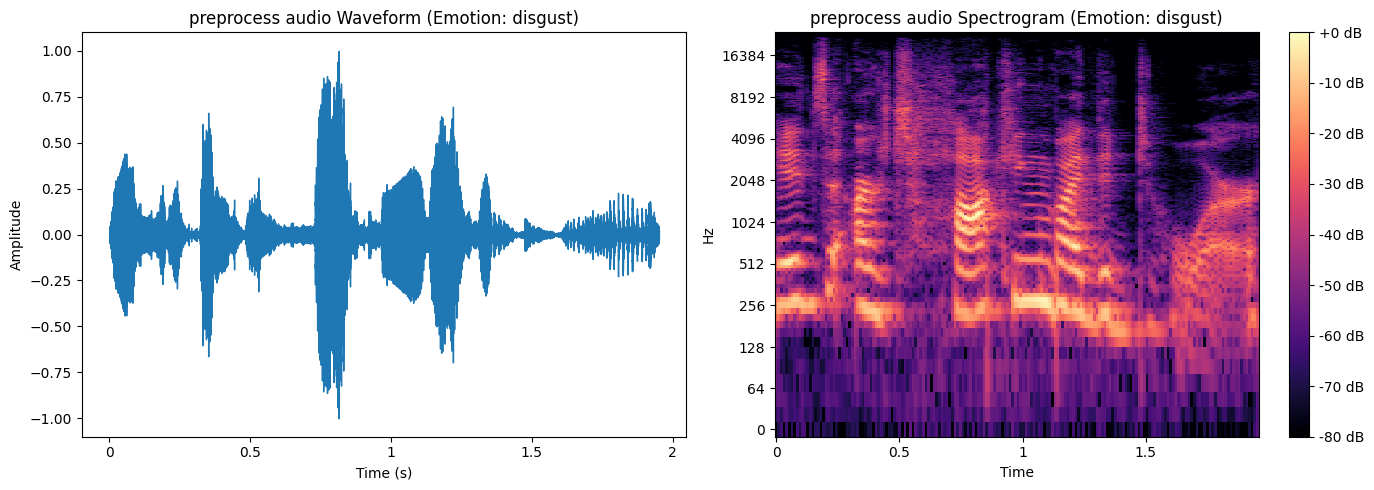


Plotting for Emotion: fearful
Modality: 03, Vocal Channel: 01, Intensity: 02, Statement: 02, Actor ID: 02,  Actor_Gender: Female


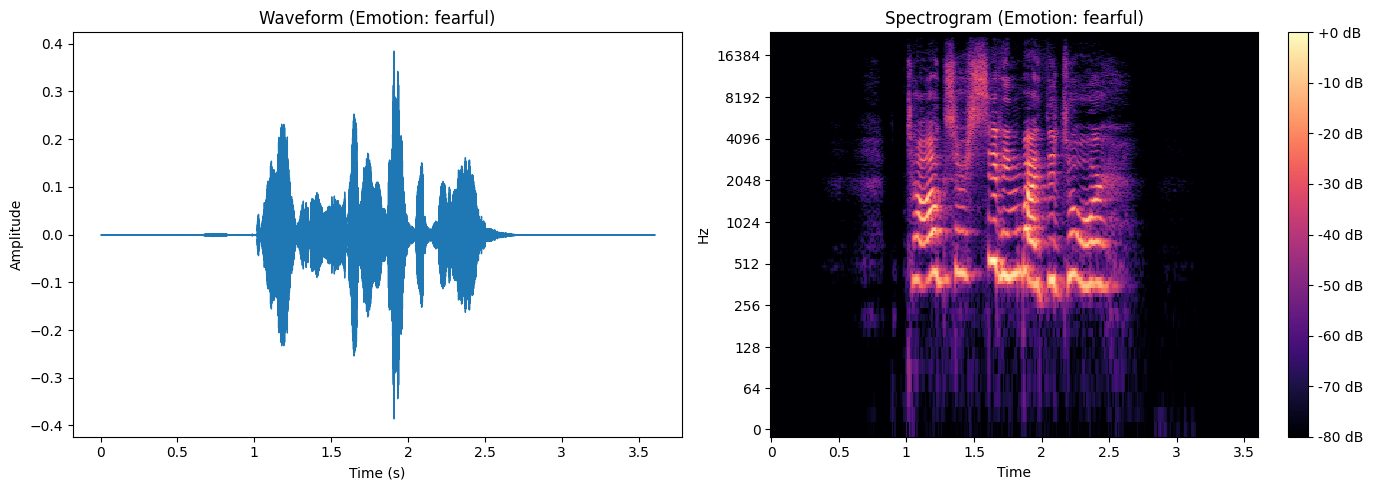

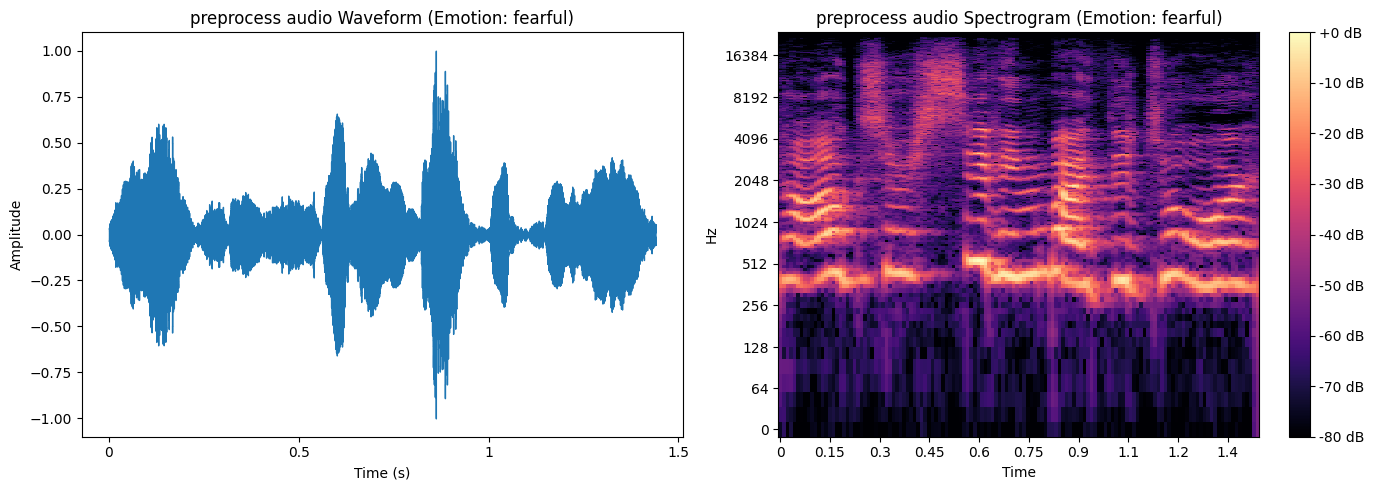


Plotting for Emotion: sad
Modality: 03, Vocal Channel: 01, Intensity: 01, Statement: 02, Actor ID: 02,  Actor_Gender: Female


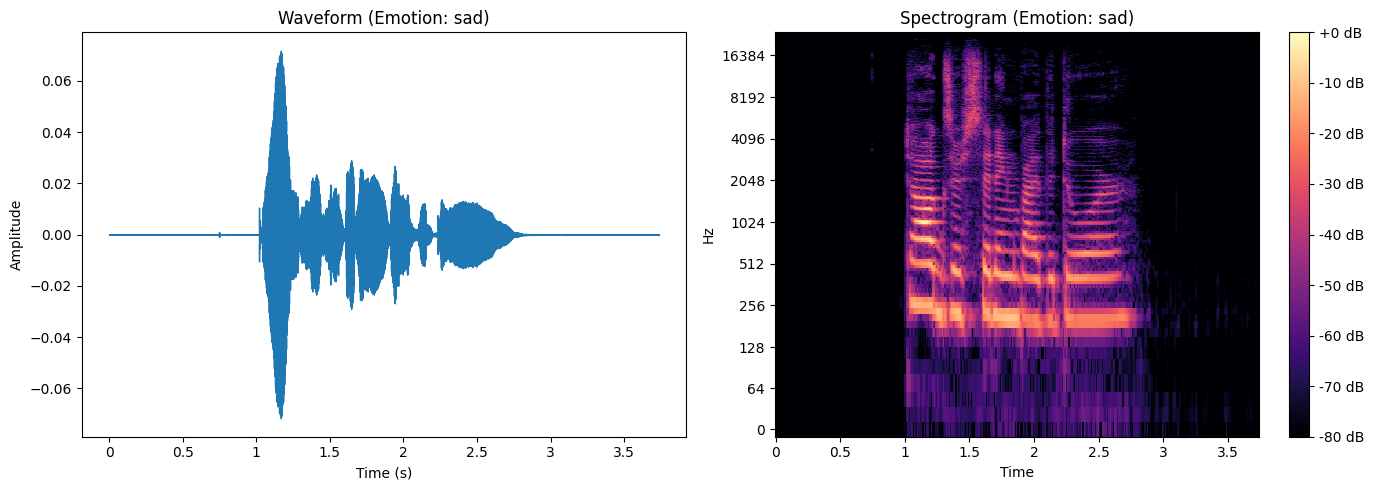

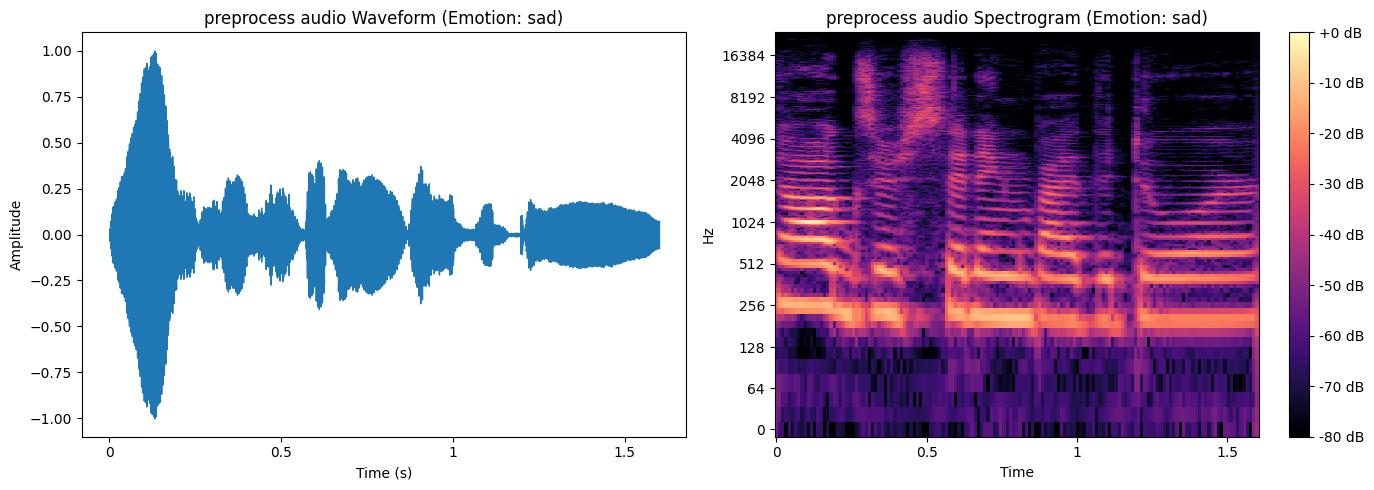


Plotting for Emotion: calm
Modality: 03, Vocal Channel: 01, Intensity: 01, Statement: 01, Actor ID: 02,  Actor_Gender: Female


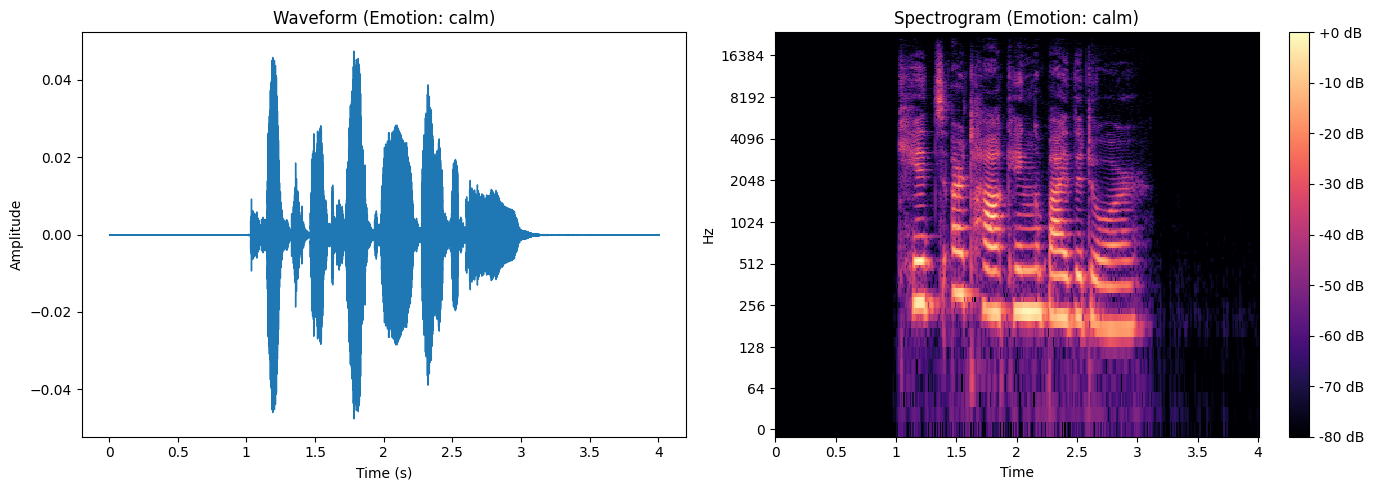

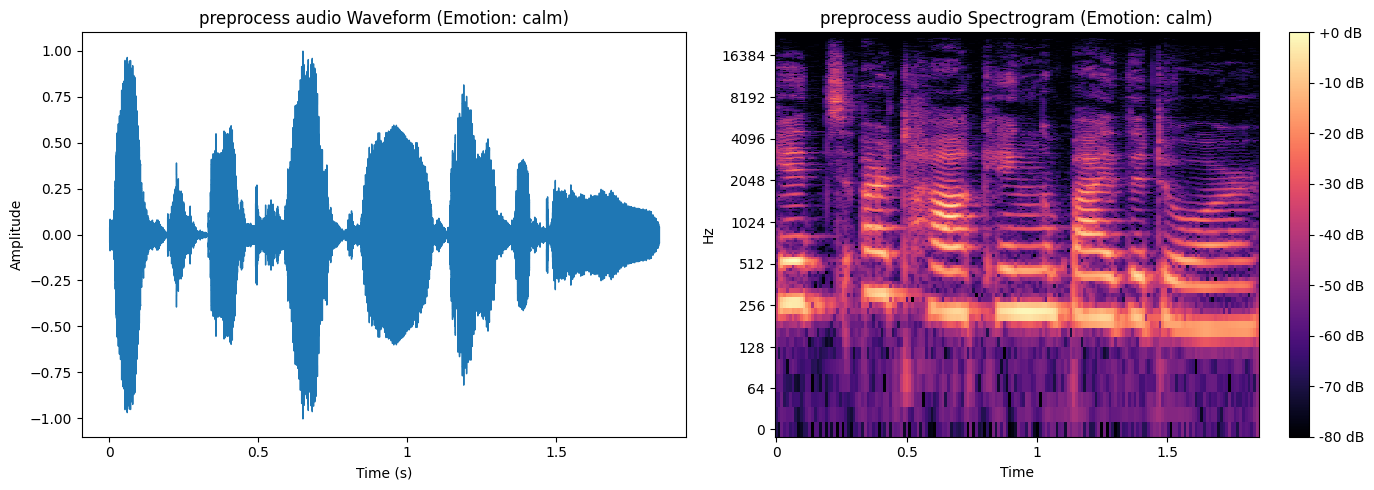


Plotting for Emotion: happy
Modality: 03, Vocal Channel: 01, Intensity: 01, Statement: 01, Actor ID: 02,  Actor_Gender: Female


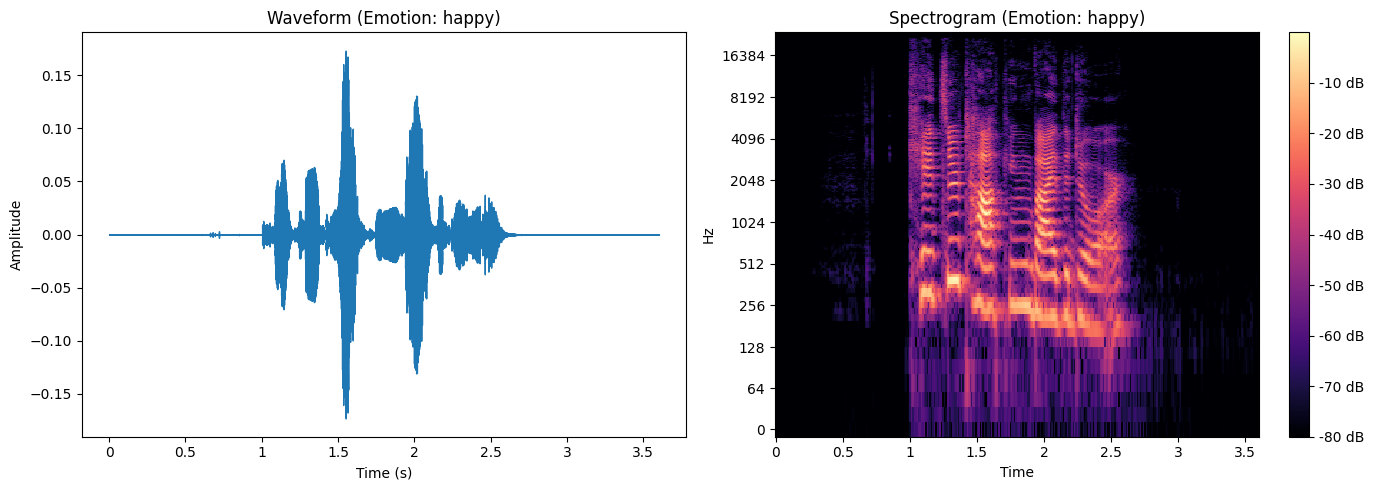

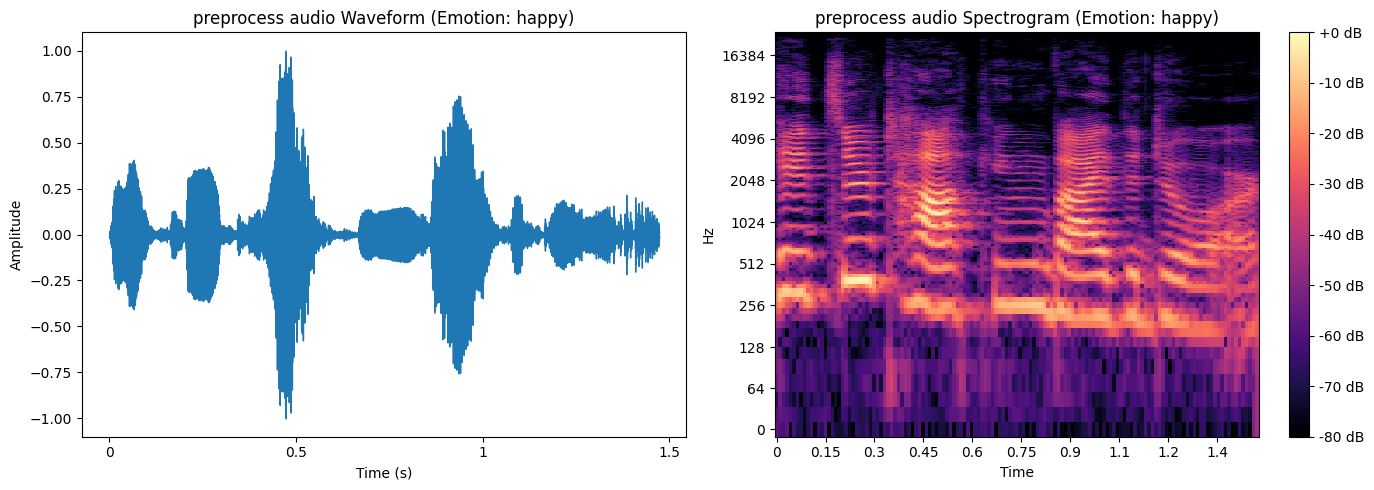


Plotting for Emotion: angry
Modality: 03, Vocal Channel: 01, Intensity: 01, Statement: 01, Actor ID: 02,  Actor_Gender: Female


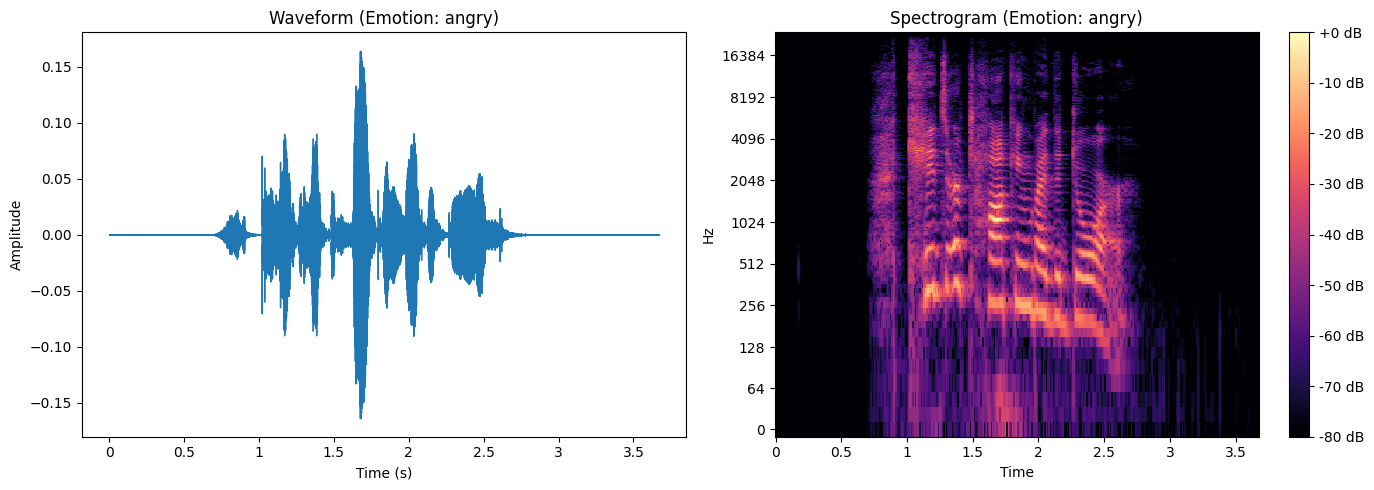

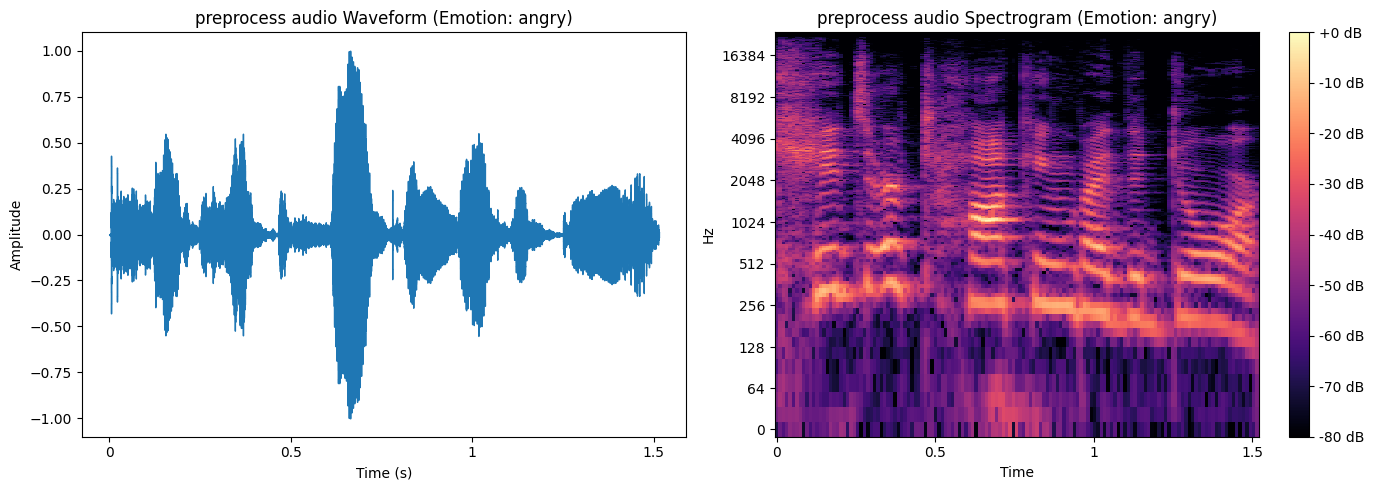


 Processing  the  file Number: 100

 Processing  the  file Number: 200

 Processing  the  file Number: 300

 Processing  the  file Number: 400

 Processing  the  file Number: 500

 Processing  the  file Number: 600

 Processing  the  file Number: 700

 Processing  the  file Number: 800

 Processing  the  file Number: 900

 Processing  the  file Number: 1000

 Processing  the  file Number: 1100

 Processing  the  file Number: 1200

 Processing  the  file Number: 1300

 Processing  the  file Number: 1400

✅ Dataset Extracted and Loaded Successfully!
Total audio files processed: 1440
Emotion distribution:
  surprised: 192 files
  neutral: 96 files
  disgust: 192 files
  fearful: 192 files
  sad: 192 files
  calm: 192 files
  happy: 192 files
  angry: 192 files

MFCC_X shape: (1440, 160)
MFCC_y shape: (1440,)


In [29]:
# Choose feature type ('MFCC' or 'WAV2VEC')
feature_type = "MFCC-48000-40"
MFCC_X, MFCC_y = data_prep.load_dataset(feature_type)

print(f"\nMFCC_X shape: {MFCC_X.shape}")
print(f"MFCC_y shape: {MFCC_y.shape}")


input_shape shape: (160, 1)
num_classes shape: 8
✅ Model compiled and this is its visualization.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 256)                 │         264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 305,864 (1.17 MB)

 Trainable params: 305,864 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 300ms/step - accuracy: 0.1223 - loss: 0.4197 - val_accuracy: 0.1319 - val_loss: 0.3959 - learning_rate: 0.0010
Epoch 2/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 306ms/step - accuracy: 0.1085 - loss: 0.4004 - val_accuracy: 0.1562 - val_loss: 0.3947 - learning_rate: 0.0010
Epoch 3/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 293ms/step - accuracy: 0.1124 - loss: 0.3964 - val_accuracy: 0.1458 - val_loss: 0.3933 - learning_rate: 0.0010
Epoch 4/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 291ms/step - accuracy: 0.1389 - loss: 0.3965 - val_accuracy: 0.1319 - val_loss: 0.3930 - learning_rate: 0.0010
Epoch 5/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 307ms/step - accuracy: 0.1157 - loss: 0.3993 - val_accuracy: 0.1319 - val_loss: 0.3930 - learning_rate: 0.0010
Epoch 6/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 296ms/step - accuracy: 0.1144 - loss: 0.3964 - val_accuracy: 0.1319 - val_loss: 0.3932 - learning_rate: 0.0010
Epoch 7/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 296ms/step - accuracy: 0.0986 - loss

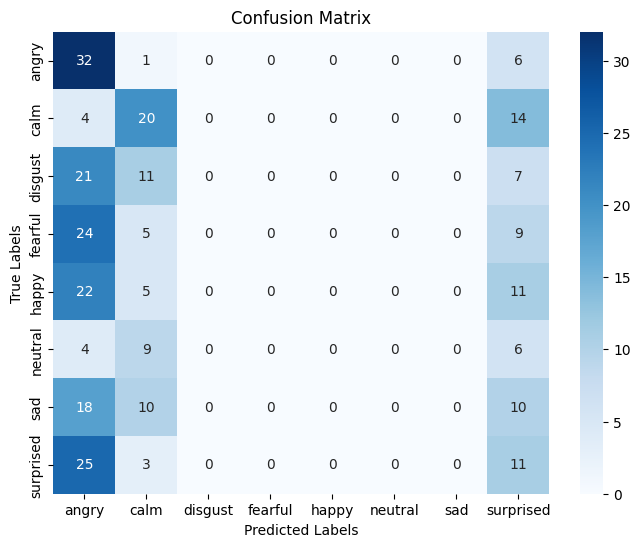

✅ Confusion Matrix plot displayed.

📈 Plotting Training History (Loss and Accuracy)...


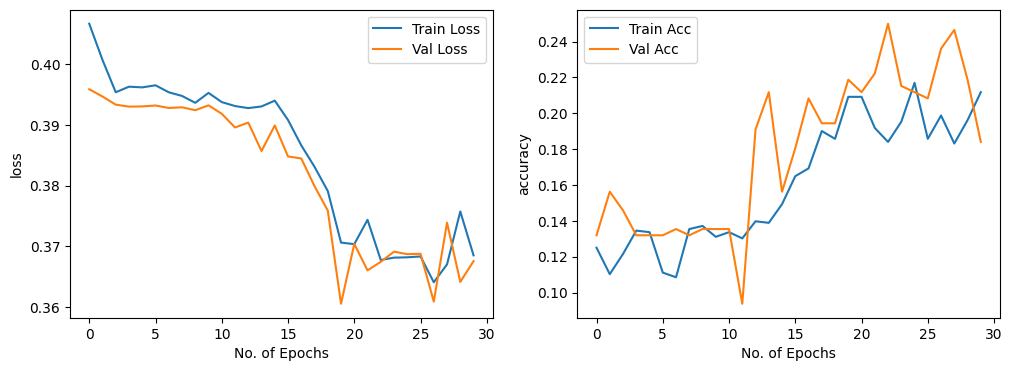

✅ Training history plot displayed.


In [31]:
Model_Type = 'LSTM' # To train "LSTM" or "CNN" or "LSTM_CNN"
model, history, labels, X_train, X_test, y_train, y_test = train_model(MFCC_X, MFCC_y, model_type= Model_Type,  test_size = 0.2, random_state = 28112912, epochs = 150, batch_size = 36, learning_rate = 0.001, loss = focal_loss(), optimizer_sel = Adam)
evaluate_model( model, history, labels, X_train, X_test, y_train, y_test )




input_shape shape: (160, 1)
num_classes shape: 8
✅ Model compiled and this is its visualization.


Model: "sequential_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_232 (Conv1D)                  │ (None, 160, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_232              │ (None, 160, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_174 (MaxPooling1D)     │ (None, 80, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_233 (Conv1D)                  │ (None, 80, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_233              │ (None, 80, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_175 (MaxPooling1D)     │ (None, 40, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_241 (Dropout)                │ (None, 40, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_234 (Conv1D)                  │ (None, 40, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_234              │ (None, 40, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_176 (MaxPooling1D)     │ (None, 20, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_25          │ (None, 256)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_183 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_242 (Dropout)                │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_184 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_243 (Dropout)                │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_185 (Dense)                    │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 166,984 (652.28 KB)

 Trainable params: 166,088 (648.78 KB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.1819 - loss: 0.3874 - val_accuracy: 0.1632 - val_loss: 0.4320 - learning_rate: 0.0010
Epoch 2/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.2577 - loss: 0.3472 - val_accuracy: 0.1736 - val_loss: 0.3980 - learning_rate: 0.0010
Epoch 3/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.2611 - loss: 0.3327 - val_accuracy: 0.2118 - val_loss: 0.3594 - learning_rate: 0.0010
Epoch 4/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.3090 - loss: 0.3096 - val_accuracy: 0.2083 - val_loss: 0.3618 - learning_rate: 0.0010
Epoch 5/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.3501 - loss: 0.2968 - val_accuracy: 0.2986 - val_loss: 0.3317 - learning_rate: 0.0010
Epoch 6/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.3506 - loss: 0.3014 - val_accuracy: 0.3819 - val_loss: 0.3127 - learning_rate: 0.0010
Epoch 7/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.3775 - loss: 0.2877 - 

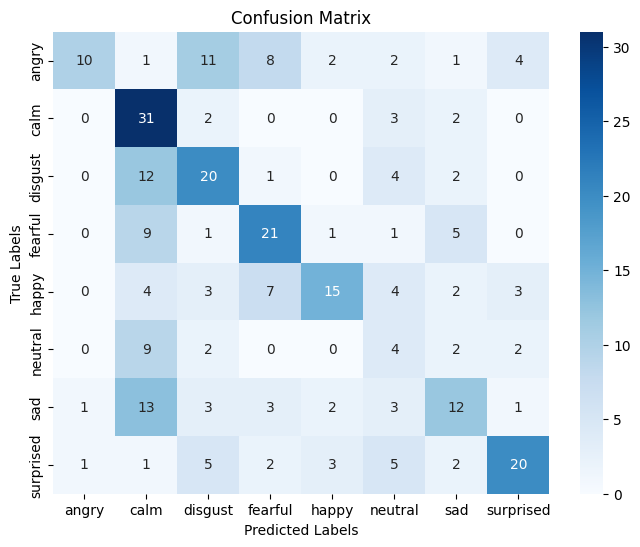

✅ Confusion Matrix plot displayed.

📈 Plotting Training History (Loss and Accuracy)...


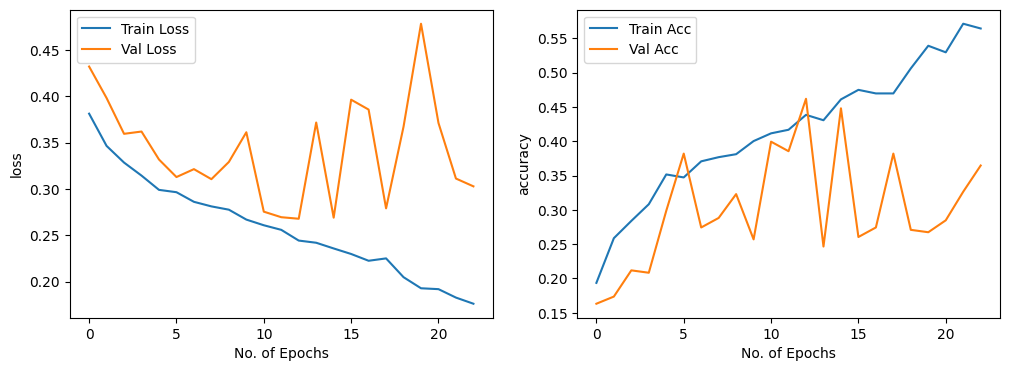

✅ Training history plot displayed.


In [169]:
Model_Type = 'CNN' # To train "LSTM" or "CNN" or "LSTM_CNN"
model, history, labels, X_train, X_test, y_train, y_test = train_model(MFCC_X, MFCC_y, model_type= Model_Type,  test_size = 0.2, random_state = 28112912, epochs = 150, batch_size = 36, learning_rate = 0.001, loss = focal_loss(), optimizer_sel = Adam)
evaluate_model( model, history, labels, X_train, X_test, y_train, y_test )


input_shape shape: (160, 1)
num_classes shape: 8
✅ Model compiled and this is its visualization.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 160, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 160, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 80, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 80, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 80, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 40, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 40, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 40, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 40, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 20, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 20, 128)             │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 8)                   │             264 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 378,344 (1.44 MB)

 Trainable params: 377,448 (1.44 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.1743 - loss: 0.3961 - val_accuracy: 0.1424 - val_loss: 0.3946 - learning_rate: 0.0010
Epoch 2/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.1467 - loss: 0.3907 - val_accuracy: 0.1424 - val_loss: 0.4147 - learning_rate: 0.0010
Epoch 3/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.1869 - loss: 0.3777 - val_accuracy: 0.1458 - val_loss: 0.4006 - learning_rate: 0.0010
Epoch 4/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.2351 - loss: 0.3592 - val_accuracy: 0.2812 - val_loss: 0.3446 - learning_rate: 0.0010
Epoch 5/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.2085 - loss: 0.3473 - val_accuracy: 0.2812 - val_loss: 0.3435 - learning_rate: 0.0010
Epoch 6/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.2262 - loss: 0.3568 - val_accuracy: 0.3438 - val_loss: 0.3176 - learning_rate: 0.0010
Epoch 7/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.2430 - loss: 0.3382 - 

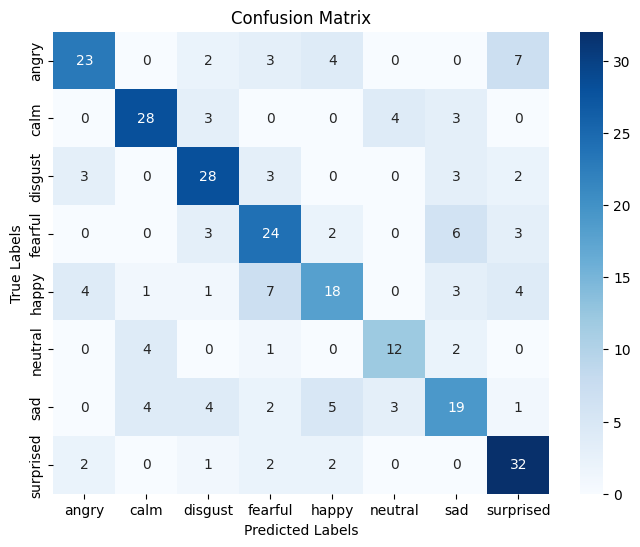

✅ Confusion Matrix plot displayed.

📈 Plotting Training History (Loss and Accuracy)...


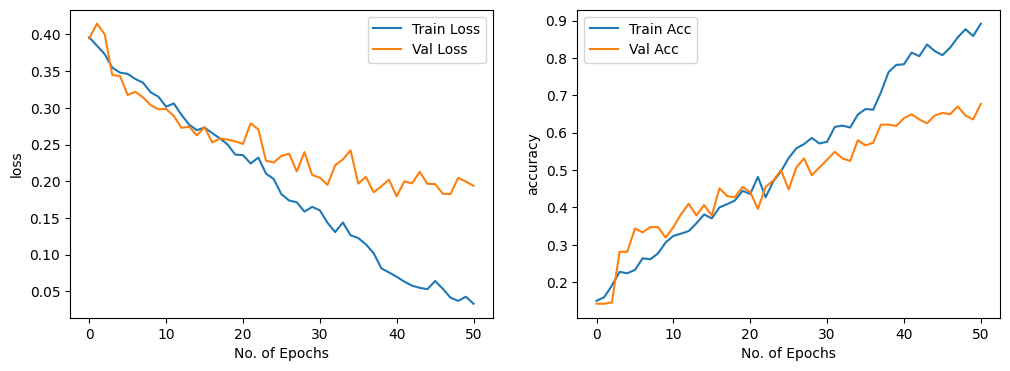

✅ Training history plot displayed.


In [32]:
Model_Type = 'LSTM_CNN' # To train "LSTM" or "CNN" or "LSTM_CNN"
model, history, labels, X_train, X_test, y_train, y_test = train_model(MFCC_X, MFCC_y, model_type= Model_Type,  test_size = 0.2, random_state = 28112912, epochs = 150, batch_size = 36, learning_rate = 0.001, loss = focal_loss(), optimizer_sel = Adam)
evaluate_model( model, history, labels, X_train, X_test, y_train, y_test )

Method: WAV2VEC
Sample Rate: 16000

🔍 Scanning dataset directory: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/

✅ Found 1440 valid audio files.


 Extracting the WAV2VEC type feature with sample_rate: 16000


Plotting for Emotion: surprised
Modality: 03, Vocal Channel: 01, Intensity: 01, Statement: 01, Actor ID: 02,  Actor_Gender: Female


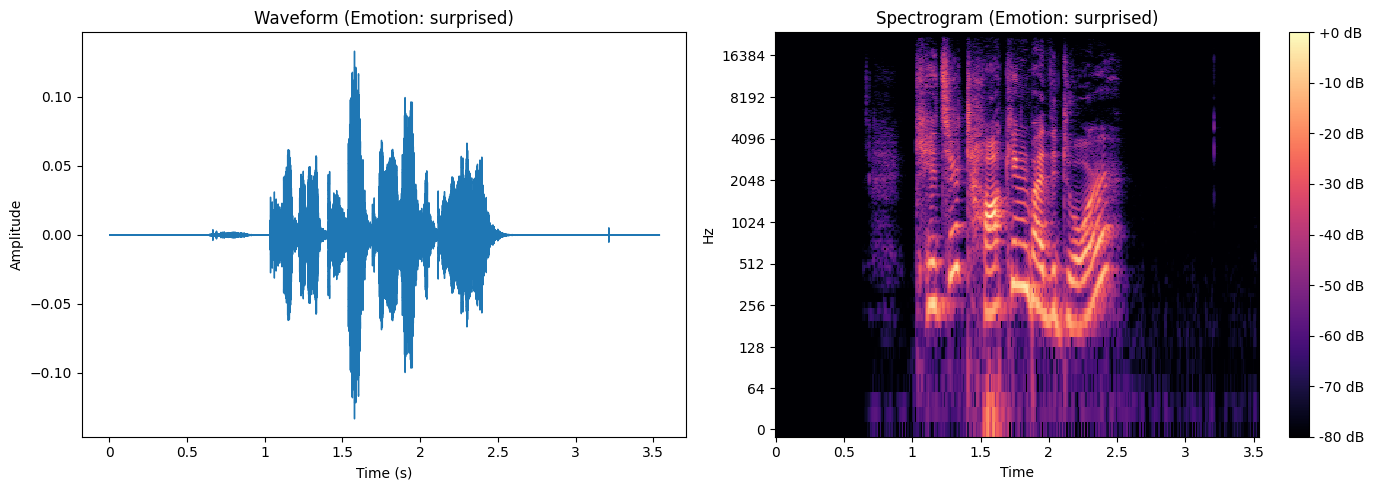

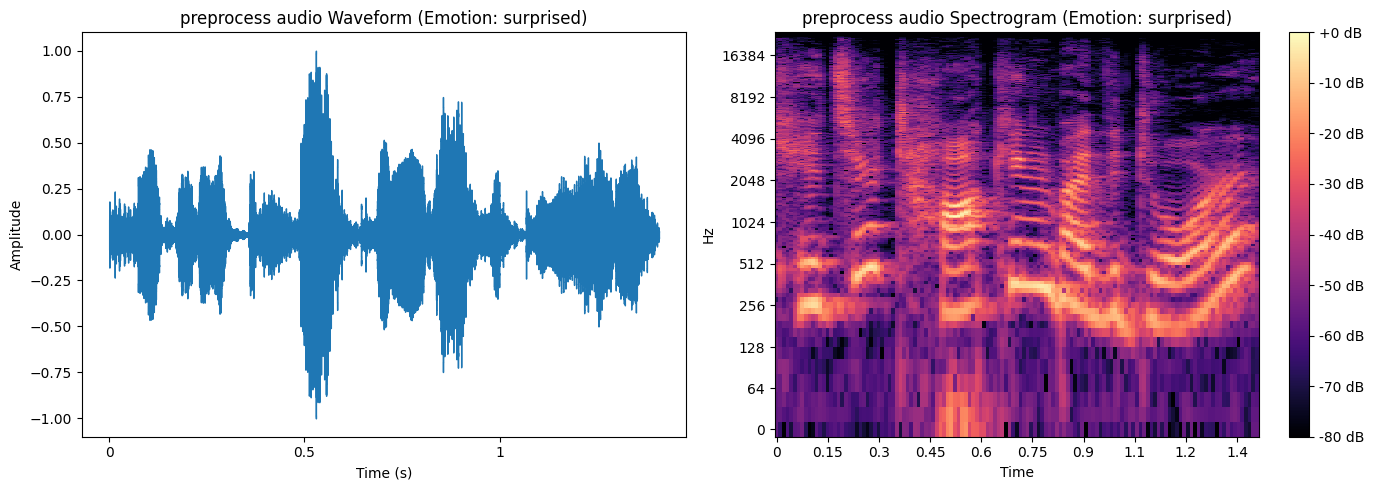


Plotting for Emotion: neutral
Modality: 03, Vocal Channel: 01, Intensity: 01, Statement: 01, Actor ID: 02,  Actor_Gender: Female


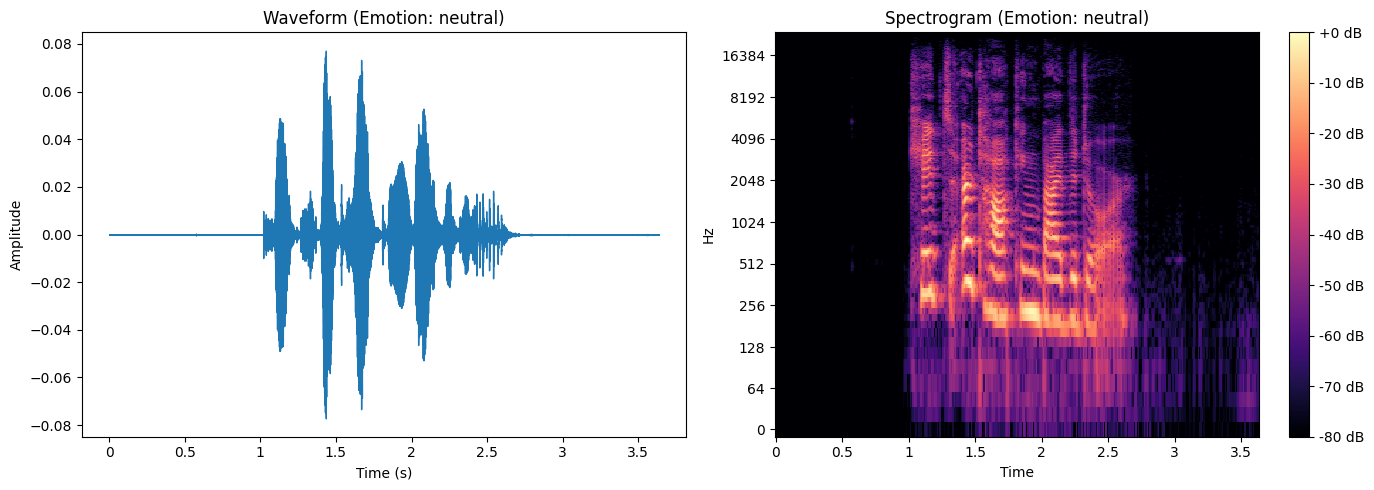

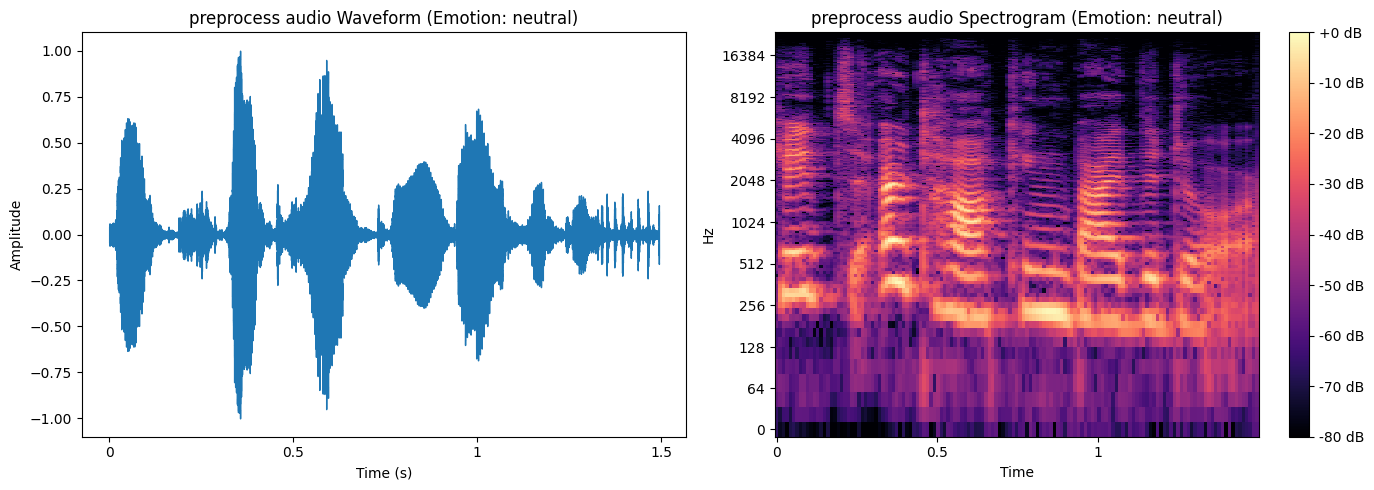


Plotting for Emotion: disgust
Modality: 03, Vocal Channel: 01, Intensity: 02, Statement: 01, Actor ID: 02,  Actor_Gender: Female


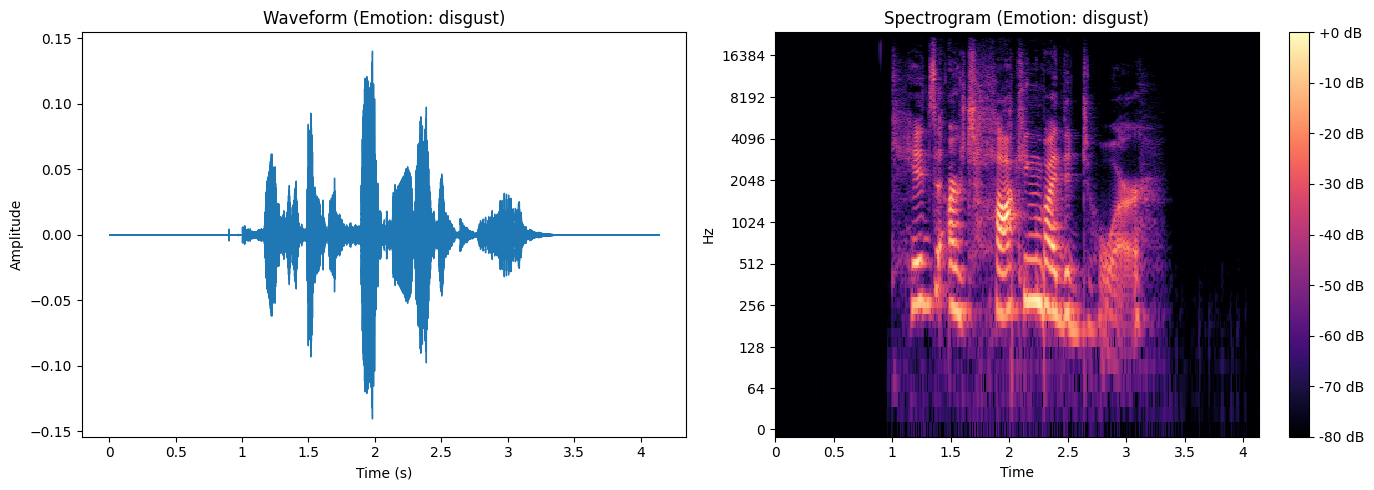

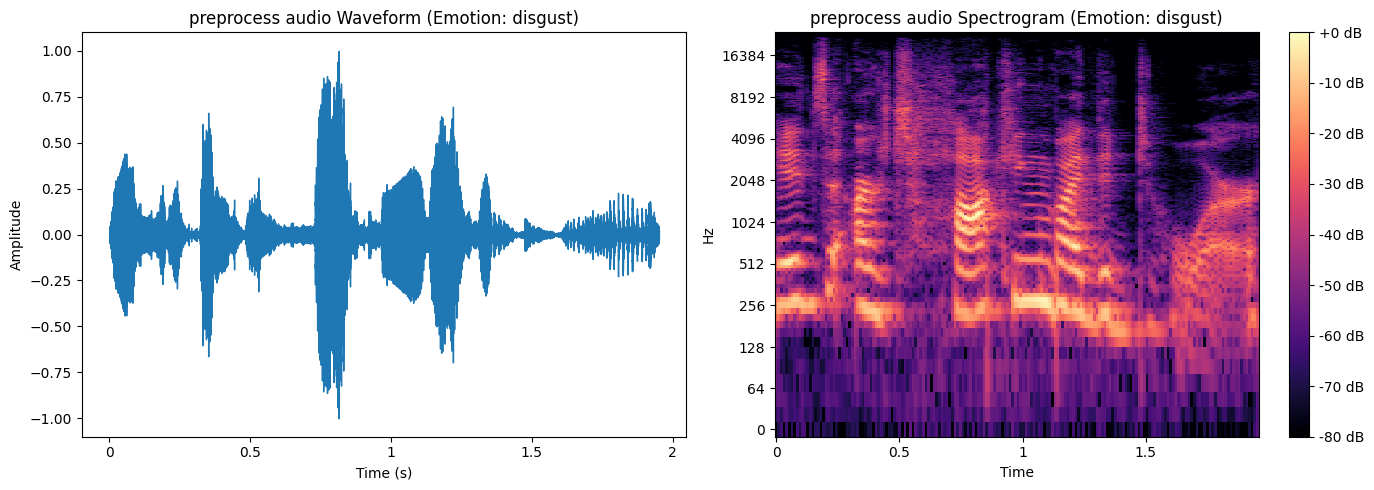


Plotting for Emotion: fearful
Modality: 03, Vocal Channel: 01, Intensity: 02, Statement: 02, Actor ID: 02,  Actor_Gender: Female


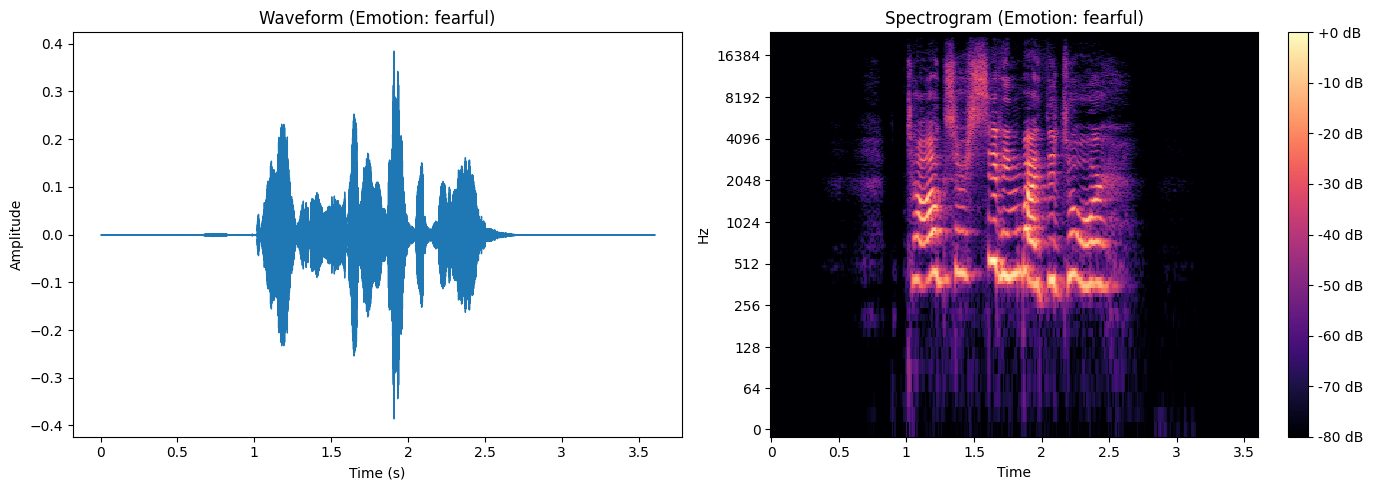

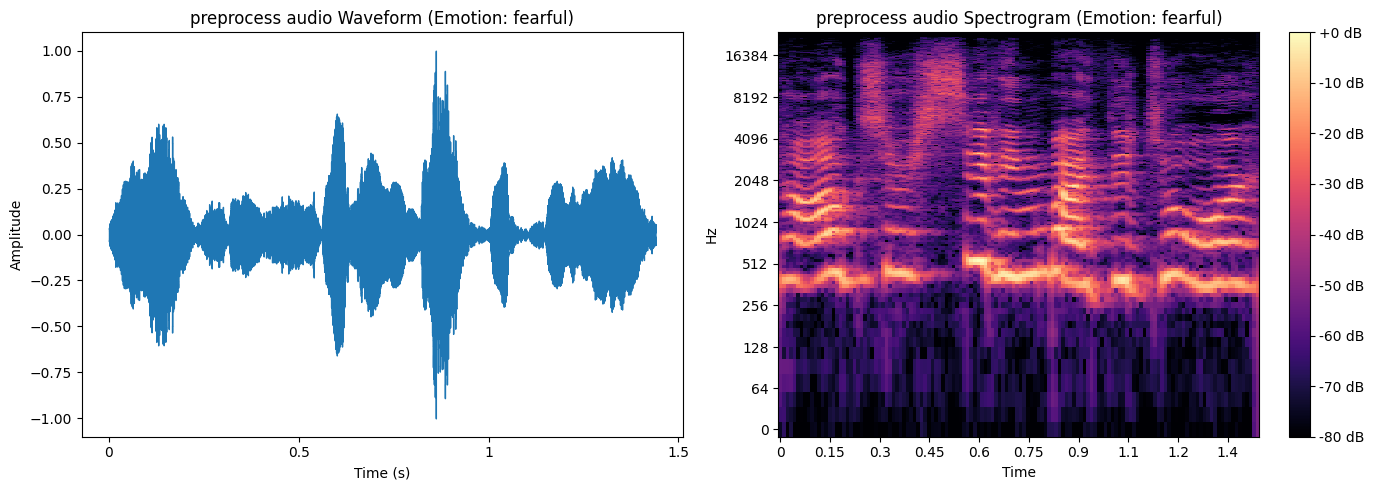


Plotting for Emotion: sad
Modality: 03, Vocal Channel: 01, Intensity: 01, Statement: 02, Actor ID: 02,  Actor_Gender: Female


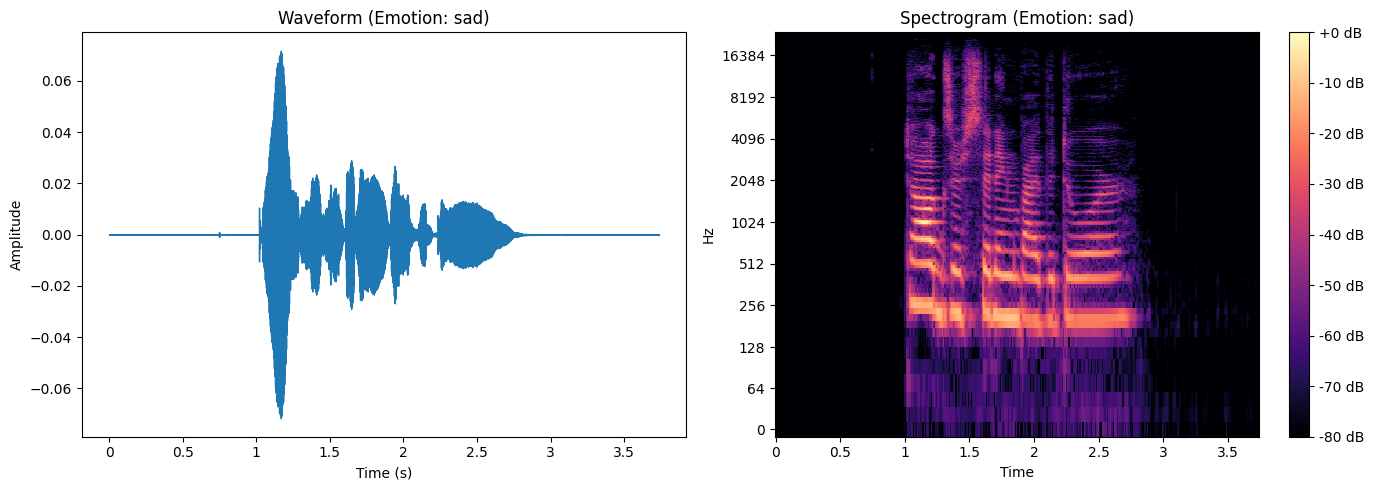

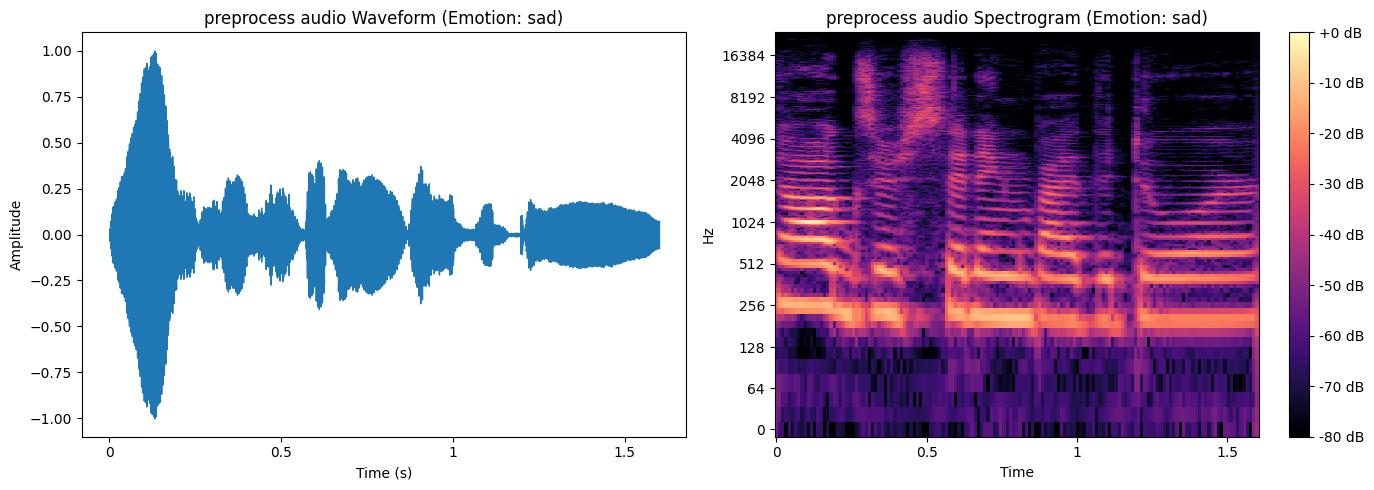


Plotting for Emotion: calm
Modality: 03, Vocal Channel: 01, Intensity: 01, Statement: 01, Actor ID: 02,  Actor_Gender: Female


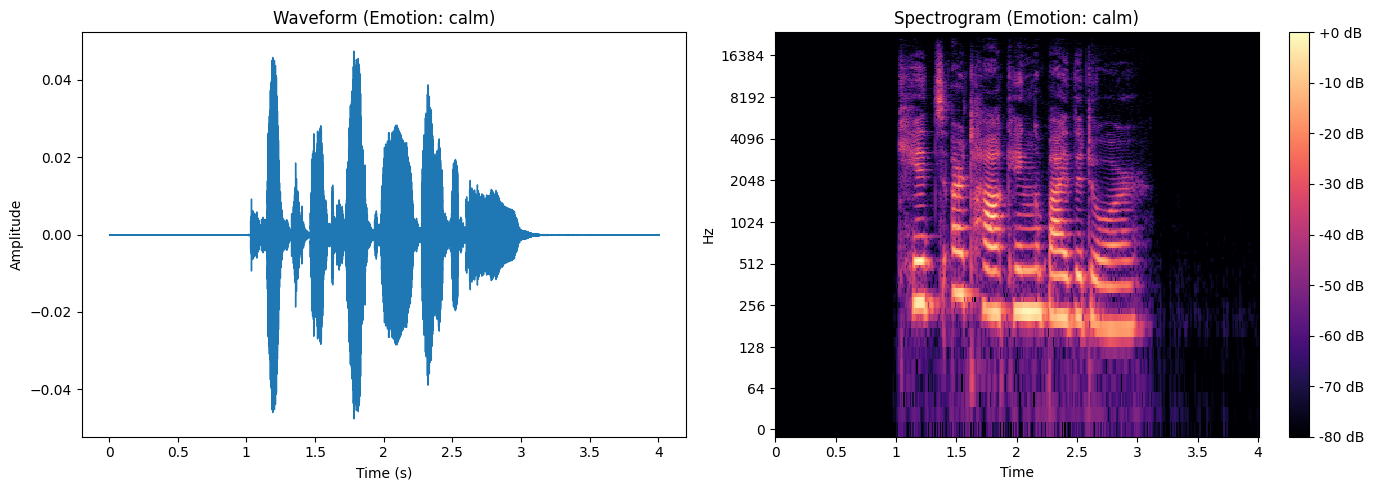

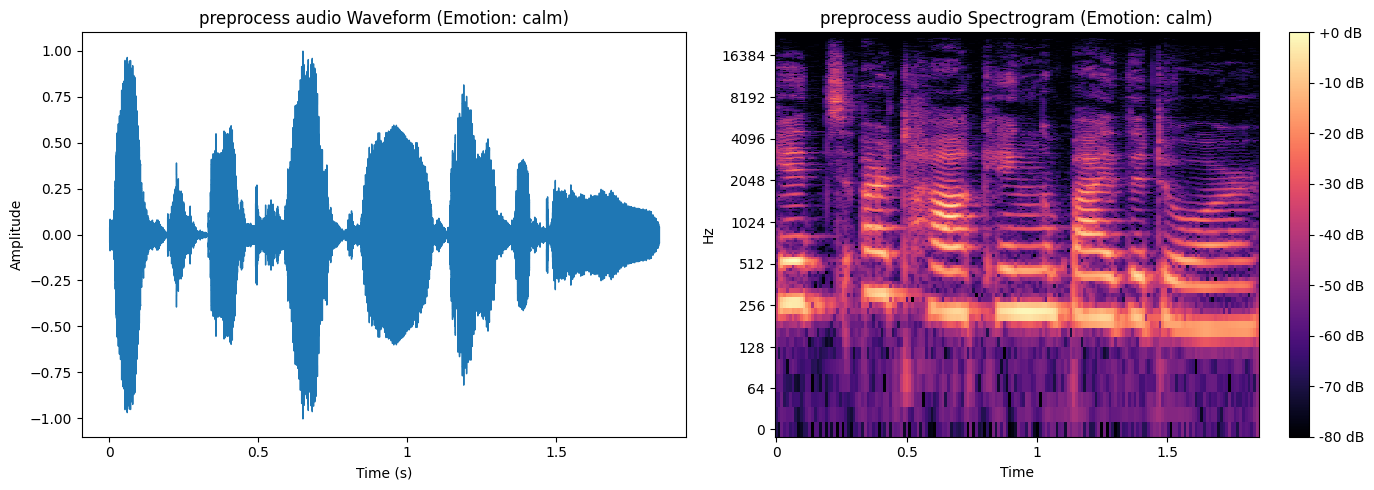


Plotting for Emotion: happy
Modality: 03, Vocal Channel: 01, Intensity: 01, Statement: 01, Actor ID: 02,  Actor_Gender: Female


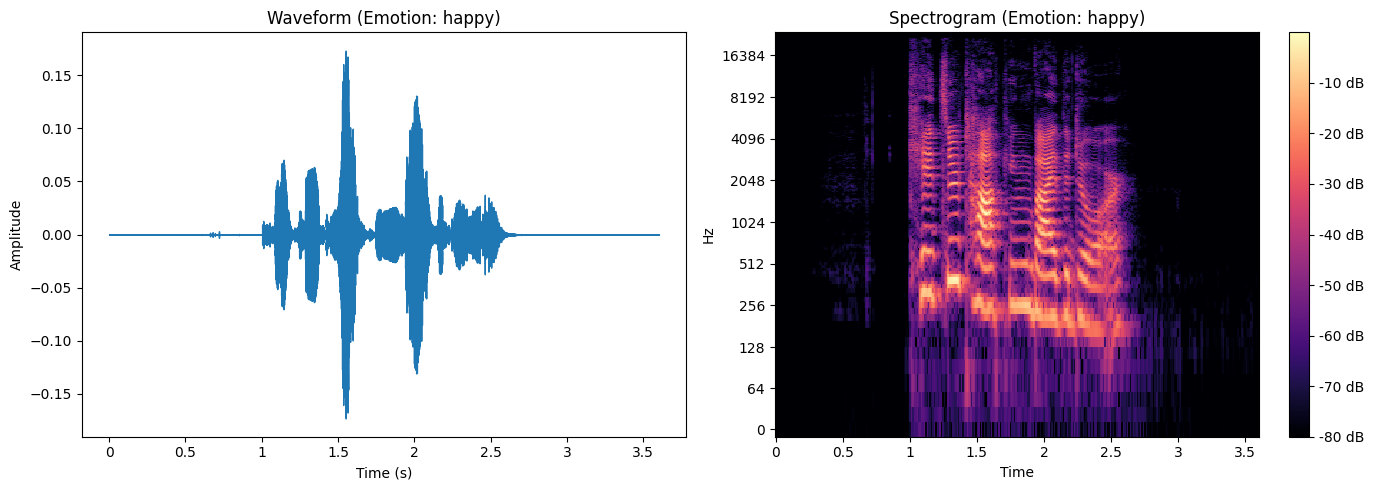

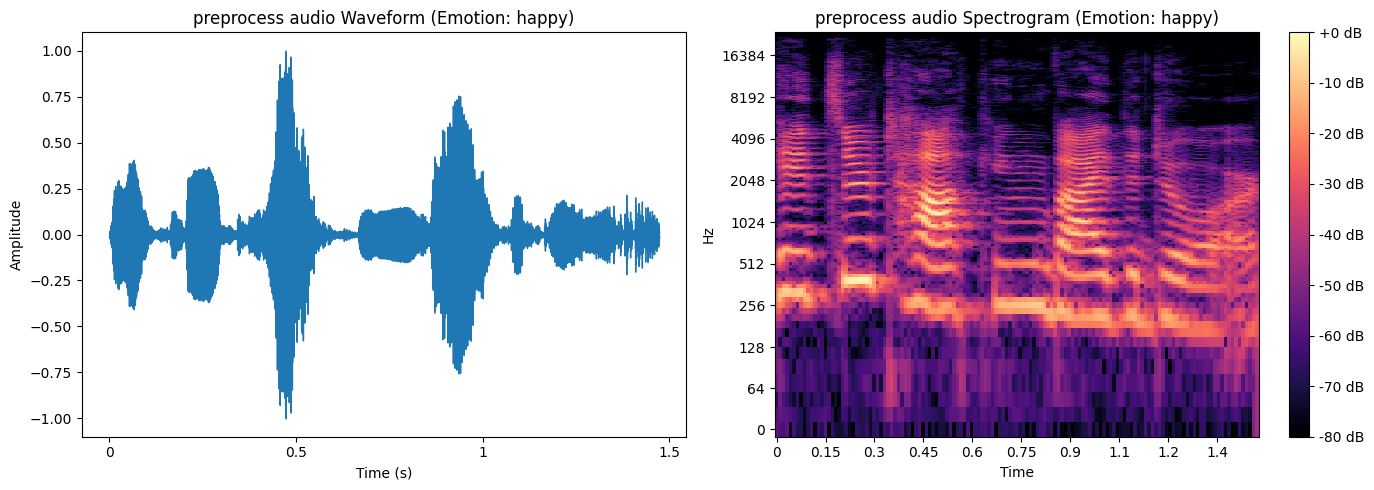


Plotting for Emotion: angry
Modality: 03, Vocal Channel: 01, Intensity: 01, Statement: 01, Actor ID: 02,  Actor_Gender: Female


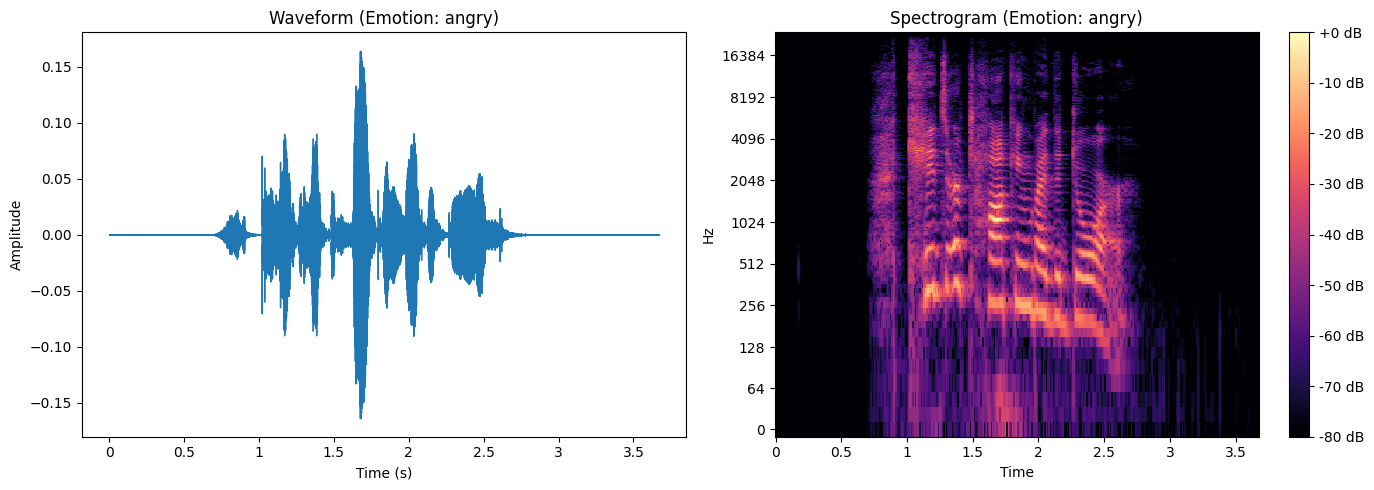

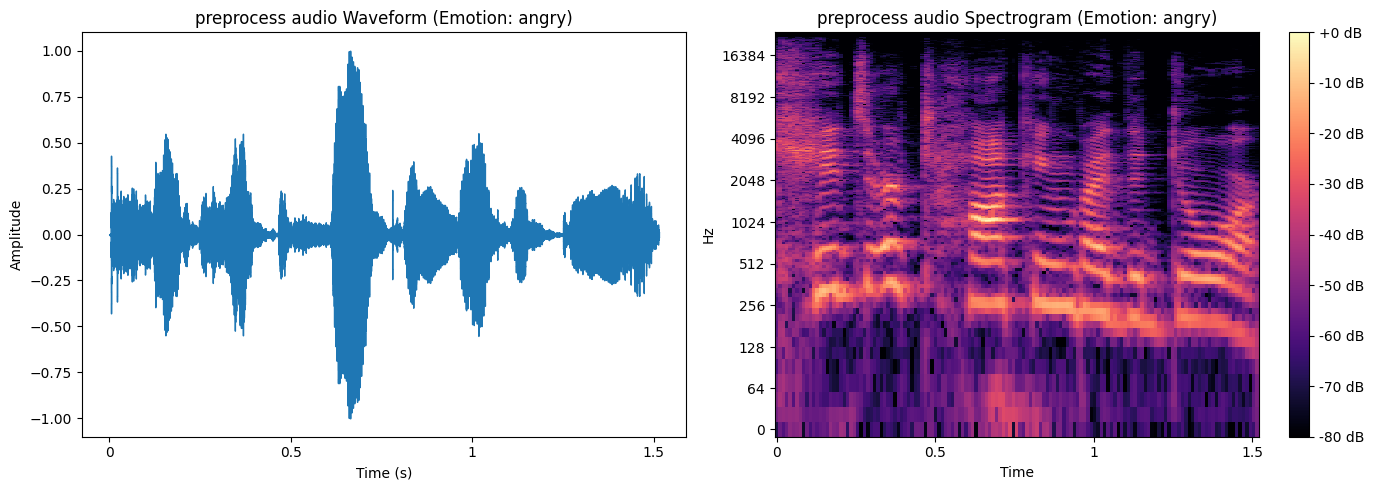


 Processing  the  file Number: 100

 Processing  the  file Number: 200

 Processing  the  file Number: 300

 Processing  the  file Number: 400

 Processing  the  file Number: 500

 Processing  the  file Number: 600

 Processing  the  file Number: 700

 Processing  the  file Number: 800

 Processing  the  file Number: 900

 Processing  the  file Number: 1000

 Processing  the  file Number: 1100

 Processing  the  file Number: 1200

 Processing  the  file Number: 1300

 Processing  the  file Number: 1400

✅ Dataset Extracted and Loaded Successfully!
Total audio files processed: 1440
Emotion distribution:
  surprised: 193 files
  neutral: 96 files
  disgust: 192 files
  fearful: 192 files
  sad: 192 files
  calm: 192 files
  happy: 192 files
  angry: 192 files

WAV2VEC_X shape: (1440, 170, 768)
WAV2VEC_y shape: (1440,)


In [21]:
# Choose feature type ('MFCC' or 'WAV2VEC')
feature_type = "WAV2VEC-16000" #  wav2vec2-base Tranined on 16Khz 
WAV2VEC_X, WAV2VEC_y = data_prep.load_dataset(feature_type)

print(f"\nWAV2VEC_X shape: {WAV2VEC_X.shape}")
print(f"WAV2VEC_y shape: {WAV2VEC_y.shape}")

In [67]:
# Encode labels
le = LabelEncoder()
WAV2VEC_y = le.fit_transform(WAV2VEC_y)
labels = le.classes_

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(WAV2VEC_X, WAV2VEC_y, test_size=0.2, random_state=93282)

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)


# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


🔮 Making predictions on the test set...
✅ Predictions completed.

🏋️‍♂️ Train Accuracy: 100.00%
🔑 Test Accuracy: 48.61%


📊 Generating Classification Report...

Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.56      0.54        32
           1       0.60      0.77      0.67        44
           2       0.47      0.63      0.54        41
           3       0.55      0.41      0.47        41
           4       0.32      0.18      0.23        39
           5       0.62      0.48      0.54        21
           6       0.34      0.29      0.32        34
           7       0.42      0.50      0.46        36

    accuracy                           0.49       288
   macro avg       0.48      0.48      0.47       288
weighted avg       0.48      0.49      0.47       288


🧩 Plotting Confusion Matrix...


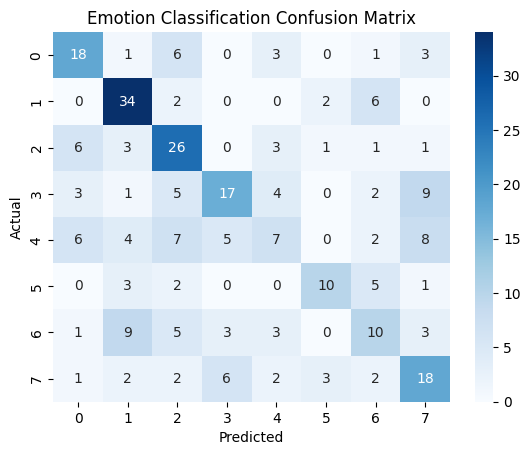

✅ Confusion Matrix plot displayed.


In [68]:

# Initialize the Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=93282)

# Train the model
clf.fit(X_train_tensor, y_train_tensor)

# Predict on the test set
y_pred_test = clf.predict(X_test_tensor)

# Predict on the train set (optional but recommended to calculate accuracy for both)
y_pred_train = clf.predict(X_train_tensor)

# Making predictions
print("\n🔮 Making predictions on the test set...")
print("✅ Predictions completed.\n")
    
# Calculate and print accuracy for both train and test set
train_accuracy = accuracy_score(y_train_tensor, y_pred_train)
test_accuracy = accuracy_score(y_test_tensor, y_pred_test)

print(f"🏋️‍♂️ Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"🔑 Test Accuracy: {test_accuracy * 100:.2f}%\n")
    
# Generate and print detailed classification report
print("\n📊 Generating Classification Report...")
report = classification_report(y_test_tensor, y_pred_test)
print("\nClassification Report:\n", report)

# Plot confusion matrix
print("\n🧩 Plotting Confusion Matrix...")
cm = confusion_matrix(y_test_tensor, y_pred_test)
# Plot confusion matrix using Seaborn heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Emotion Classification Confusion Matrix")
plt.show()
print("✅ Confusion Matrix plot displayed.")


In [375]:
# num_features = X_train_tensor.shape[1]  # Number of features
# feature_names = [f"feature{i+1}" for i in range(num_features)]  # Generate feature names
# # Feature Importances: Track the importance of each feature
# feature_importances = clf.feature_importances_
# print("Feature Importances:\n", feature_importances)

# # Track the individual trees and print out the first tree
# first_tree = clf.estimators_[0]
# print("\nFirst Tree Structure:")
# tree_structure = export_text(first_tree, feature_names=feature_names)
# print(tree_structure)

# # Track cross-validation scores (optional: if you want to see performance over iterations)
# cv_scores = cross_val_score(clf, X_train_tensor, y_train, cv=5)
# print(f"\nCross-validation scores: {cv_scores}")
# print(f"Mean cross-validation score: {cv_scores.mean():.2f}")

# # Optional: You can iterate over all trees in the Random Forest and display their structure
# print("\nDisplaying Structures of All Trees in the Random Forest (First 3 trees):")
# for i, tree in enumerate(clf.estimators_[:3]):  # Only showing the first 3 trees for brevity
#     print(f"\nTree {i+1} Structure:")
#     print(export_text(tree, feature_names=feature_names))